<a href="https://colab.research.google.com/github/noahnguyen2004/Loan-Default-Prediction/blob/main/loan_lending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
!pip install scikit-plot

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import plotly.express as px
from scipy.stats import boxcox

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from scikitplot.metrics import plot_roc_curve

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import AUC

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [218]:
df = pd.read_csv('/content/drive/MyDrive/loan default/loan_lending_club.csv', encoding = 'latin-1',
                 usecols=['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
                            'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'dti',
                            'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type',
                            'mort_acc', 'pub_rec_bankruptcies'])
df

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,5000.00,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.00,Verified,Dec-2011,Fully Paid,credit_card,Computer,27.65,Jan-1985,3.00,0.00,13648.00,83.7%,9.00,f,Individual,NaN,0.00
1,2500.00,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.00,Source Verified,Dec-2011,Charged Off,car,bike,1.00,Apr-1999,3.00,0.00,1687.00,9.4%,4.00,f,Individual,NaN,0.00
2,2400.00,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.00,Not Verified,Dec-2011,Fully Paid,small_business,real estate business,8.72,Nov-2001,2.00,0.00,2956.00,98.5%,10.00,f,Individual,NaN,0.00
3,10000.00,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.00,Source Verified,Dec-2011,Fully Paid,other,personel,20.00,Feb-1996,10.00,0.00,5598.00,21%,37.00,f,Individual,NaN,0.00
4,3000.00,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.00,Source Verified,Dec-2011,Fully Paid,other,Personal,17.94,Jan-1996,15.00,0.00,27783.00,53.9%,38.00,f,Individual,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925489,10000.00,36 months,7.99%,313.32,A,A5,Rn,10+ years,MORTGAGE,65000.00,Source Verified,Apr-2017,Fully Paid,debt_consolidation,Debt consolidation,19.55,Sep-1993,15.00,0.00,9751.00,15.7%,27.00,w,Individual,0.00,0.00
2925490,10050.00,36 months,16.99%,358.26,D,D1,Sales Associate,8 years,RENT,37000.00,Not Verified,Apr-2017,Charged Off,debt_consolidation,Debt consolidation,20.56,May-1993,15.00,0.00,14300.00,47%,21.00,w,Individual,0.00,0.00
2925491,6000.00,36 months,11.44%,197.69,B,B4,Contact input,5 years,RENT,41000.00,Source Verified,Apr-2017,Fully Paid,credit_card,Credit card refinancing,19.99,May-1990,9.00,0.00,1356.00,10.1%,18.00,w,Individual,0.00,0.00
2925492,30000.00,60 months,25.49%,889.18,E,E4,Assistant Manager,4 years,MORTGAGE,105700.00,Verified,Apr-2017,Charged Off,debt_consolidation,Debt consolidation,27.26,Nov-1997,12.00,0.00,15252.00,72.6%,23.00,w,Individual,3.00,0.00


# Data preprocessing

In [219]:
loan_status_counts = df['loan_status'].value_counts()

loan_status_df = pd.DataFrame({
    'Loan Status': loan_status_counts.index,
    'Counts': loan_status_counts.values
})

loan_status_df

,Loan Status,Counts
0,Fully Paid,1497783
1,Current,1031016
2,Charged Off,362548
3,Late (31-120 days),16154
4,In Grace Period,10028
5,Late (16-30 days),2719
6,Issued,2062
7,Does not meet the credit policy. Status:Fully ...,1988
8,Does not meet the credit policy. Status:Charge...,761
9,Default,433


The goal of this project is to predict whether a borrower can pay off the installments or not, so only Fully Paid and Charged Off are taken into account.
- Charged Off: the borrower has become delinquent for a period of time and the company did not believe the borrower can pay back the loan amount, but the borrower still has the responsibility to do so.

In [ ]:
# retain binary class (Fully Paid, Charged Off) for loan_status as target, and drop the rest
df.drop(df[df['loan_status'] == 'Late (31-120 days)'].index, inplace = True)
df.drop(df[df['loan_status'] == 'In Grace Period'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Current'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Late (16-30 days)'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Issued'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Default'].index, inplace = True)

df = df.reset_index(drop=True)
df

## Appropriate data type of each feature
- loan_amnt: numerical -> float
- term: categorical -> string
- int_rate: numerical -> float
- installment: numerical -> float
- grade: categorical -> string
- sub_grade: categorical -> string
- emp_title: categorical -> string
- emp_length: categorical -> string
- home_ownership: categorical -> string
- annual_inc: numerical -> float
- verification_status: categorical -> string
- issue_d: categorical -> string
- loan_status: categorical (target) -> string
- purpose: categorical -> string
- title: categorical -> string
- dti: numerical -> float
- earliest_cr_line: categorical -> string
- open_acc: numerical -> float
- pub_rec: categorical -> int
- revol_bal: numerical -> float
- revol_util: numerical -> float
- total_acc: numerical -> float
- initial_list_status: categorical -> string
- application_type: categorical -> string
- mort_acc: numerical -> int
- pub_rec_bankruptcies: numerical -> int

### We notice some issues:
- **Inappropriate data types:** the values in the `int_rate` column contain % sign, which does not represent float data type. We would drop the % sign and convert `int_rate` values into float. The same with `revol_util`.
- **Date and time:** there are a lot of different dates in the dataset, so we would want to visualize date and time in the form of YYYY only.
- **Missing values:** typical problem occurred in tabular data. We should address the meaning of these missing values in each column before deciding to drop or keep.
- **Excessive values in columns:** the `emp_title` column, for example, contains a lot of different employment titles. We don't really need all of them, so we would take the top 2x titles that are most likely to afford a loan.


## Dealing with inappropriate data types

In [221]:
df['int_rate'] = df['int_rate'].str.replace('%', '').astype(float)      # drop % sign in values of int_rate and convert into float
df['revol_util'] = df['revol_util'].str.replace('%', '').astype(float)  # drop % sign in values of revol_util and convert into float

In [222]:
df['issue_d'] = pd.to_datetime(df['issue_d'])                           # convert into YYYY-MM-DD data type
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])         # convert into YYYY-MM-DD data type

## Dealing with excessive values in each feature

### `emp_title` and `emp_length`
As `emp_title` and `emp_length` contain too many null (NaN) values, they can badly affect the model performance later, specifically bias, or high variance if we try to fill in with mean, median, or other types of data. We would be tempted to drop those columns. However, `emp_title` and `emp_length` may contribute to the ability in paying off installments as an employment title may show how stable it is to be approved for a loan. The same goes for employment length.

- for `emp_title`, consider the top 20 titles that are most likely able to afford loans.

In [ ]:
df['emp_length'].value_counts()

In [ ]:
df['emp_title'].value_counts()[:20]       # top 20 employment titles with most loan borrowed

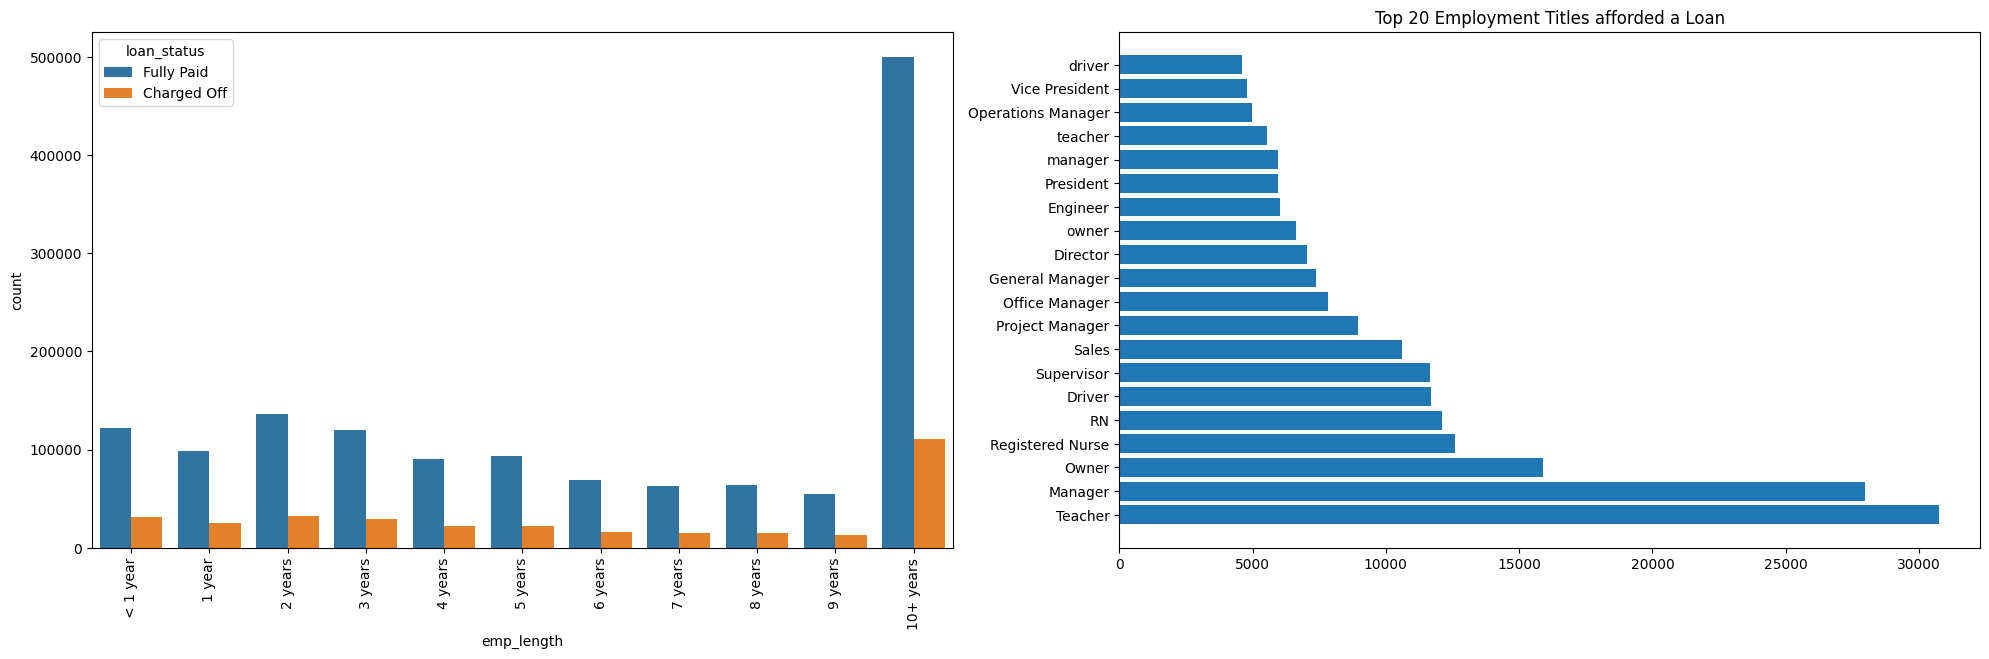

In [ ]:
# @title
plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
g = sns.countplot(data=df, x='emp_length', hue='loan_status', order=order)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

plt.subplot(2, 2, 2)
plt.barh(df['emp_title'].value_counts()[:20].index, df['emp_title'].value_counts()[:20])
plt.title("Top 20 Employment Titles afforded a Loan")
plt.tight_layout()

Borrowers with more than 10 years of working are more likely to pay off loans. Thus, teacher represents a stable job with long-term employment, and they most likely afford the loans. Meanwhile, driver shows a less stable employment so they can't afford loan as well as other top 20 employment titles

### `purpose` and `title`


In [ ]:
df['purpose'].value_counts()

In [ ]:
df['title'].value_counts()

[Text(0, 0, 'credit_card'),
 Text(1, 0, 'car'),
 Text(2, 0, 'small_business'),
 Text(3, 0, 'other'),
 Text(4, 0, 'wedding'),
 Text(5, 0, 'debt_consolidation'),
 Text(6, 0, 'home_improvement'),
 Text(7, 0, 'major_purchase'),
 Text(8, 0, 'medical'),
 Text(9, 0, 'moving'),
 Text(10, 0, 'vacation'),
 Text(11, 0, 'house'),
 Text(12, 0, 'renewable_energy'),
 Text(13, 0, 'educational')]

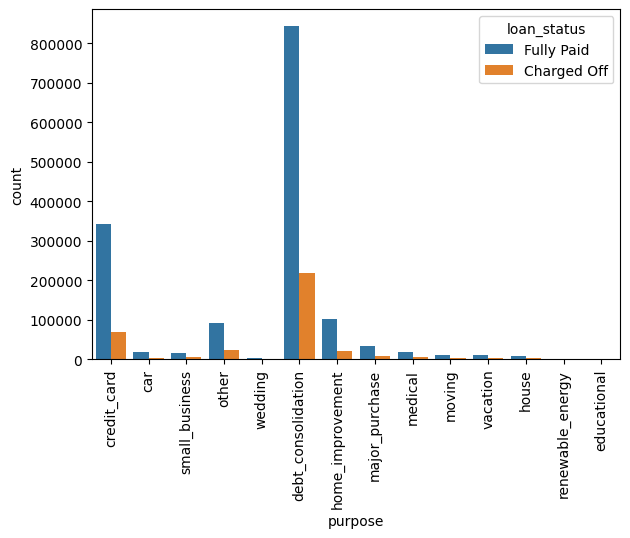

In [ ]:
# @title
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
g = sns.countplot(data=df, x='purpose', hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

## Dealing with missing values

### What does `NaN` mean?
#### Employment title and employment length
- In the context of employment length and employment title, NaN may indicate that the borrower is not currently being employed. That doesn't mean that borrower couldn't afford a loan, as they might receive money from some income sources, such as their family's income. Therefore we would look into null values of the employment length.
- As a lot of those without employment title own mortgage and have high annual income, let's not drop the null values here. Instead, map them to 0 years to indicate that they are not currently employed. There will be no missing values left for `emp_length`.

#### Annual income
- In terms of Annual income, NaN presents a lack of proof that a borrower is capable of paying the installments. Thus, examine the NaN values in `annual_inc` closely.

#### Purpose & title
- in terms of `purpose` and `title`, if a borrower doesn't specify the purpose to borrow the loan, it may state that it's not that trustworthy to lend the loan to this borrower.

#### Earliest credit line
- Earliest credit line refers to the date when the borrower's first credit account was opened.
- A lender takes this indicator into account to see your credit score history and evaluate creditworthiness. If the information about `earliest_cr_line` is missing, the lender might not be confidentas much to give you a loan since they have an incomplete picture of the credit history.
- However, it is not a factor that directly affects the ability in qualifying for a loan. The lender might consider other factors to determine.

#### Debt-to-income ratio (DTI)
- This is an indicator measuring the ability in managing the monthly payment to pay off loans.
- DTI = (all monthly debt payment) / (gross monthly income)
- A lower DTI indicates that a borrower earns more grossly monthly income and has less debt to manage => positive impact on credit score => candidates for loan approval.
- Meanwhile a higher DTI shows that the borrower earns less but potentially has more debts to manager => negative impact on credit score => less likely to be qualified for a loan.
- DTI is a very important indicator, directly affecting the ability of qualifying for a loan. Thus, missing DTI values should be addressed carefully. We would plot a distribution to visualize the DTI values of each record, and see how we can deal with the missing values.

#### Title
- We notice a pattern between `purpose` and `title` as `title` is just a subset of `purpose`. It describes the purpose in detail, while the general purpose is good enough. Therefore, we will remove this feature column.

In [227]:
def null_value_counts(data):
  '''
    Count null values in each feature column
  '''
  data_null = {}
  for col in data.columns:
    num_null = data[col].isna().sum()
    data_null[col] = [num_null]
  data_null = pd.DataFrame(data_null, index=[0]).T
  data_null = data_null.rename(columns = {0: 'Number of NaN values'})
  return data_null

In [228]:
df = df.dropna(how='all')             # first drop records whose column values are all NaN

### `emp_length`

In [ ]:
df['emp_length'] = df['emp_length'].fillna('0 years')         # replace all missing values in emp_length with "0 years"

### `emp_title`

In [ ]:
df['emp_title'] = df['emp_title'].fillna('OTHER')         # replace missing values in emp_title with OTHER

### `title`

In [ ]:
df['title'] = df['title'].fillna('OTHER')                 # replace missing values in title with OTHER

### `dti`
We would perform mean imputing for the missing values.

In [ ]:
dti_mean = df['dti'].mean()
df['dti'] = df['dti'].fillna(dti_mean)

### `mort_acc` & `pub_rec_bankruptcies`
Here we wouldn't apply the same logic of mean imputing the missing values, as the columns contain the number of mortgage accounts and number of public record bankruptcies, which must be of `int` type.

- We can still apply the mean imputing method, but then round up the mean to the nearest integer.

In [ ]:
mort_acc_mean = df['mort_acc'].mean().round()
pub_rec_bankrupt_mean = df['pub_rec_bankruptcies'].mean().round()

df['mort_acc'] = df['mort_acc'].fillna(mort_acc_mean)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(pub_rec_bankrupt_mean)

### `revol_util`

In [ ]:
rev_util_mean = df['revol_util'].mean()
df['revol_util'] = df['revol_util'].fillna(rev_util_mean)

Now if you reload the table showing the NaN values in each column, all NaN values have either been removed or imputed.

In [235]:
df_null = null_value_counts(df)
df_null

,Number of NaN values
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_title,0
emp_length,0
home_ownership,0
annual_inc,0


It does not make sense that a person has 2.67 open credit lines, or 3.69 mortgage accounts, so we should convert the existing float data type into int.

In [ ]:
df['open_acc'] = df['open_acc'].astype(int)
df['pub_rec'] = df['pub_rec'].astype(int)
df['total_acc'] = df['total_acc'].astype(int)
df['mort_acc'] = df['mort_acc'].astype(int)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].astype(int)

## Numerical features
- `loan_amnt`, `int_rate`, `installment`, `annual_inc`, `dti`, `revol_bal`, `revol_util`

(0.0, 100.0)

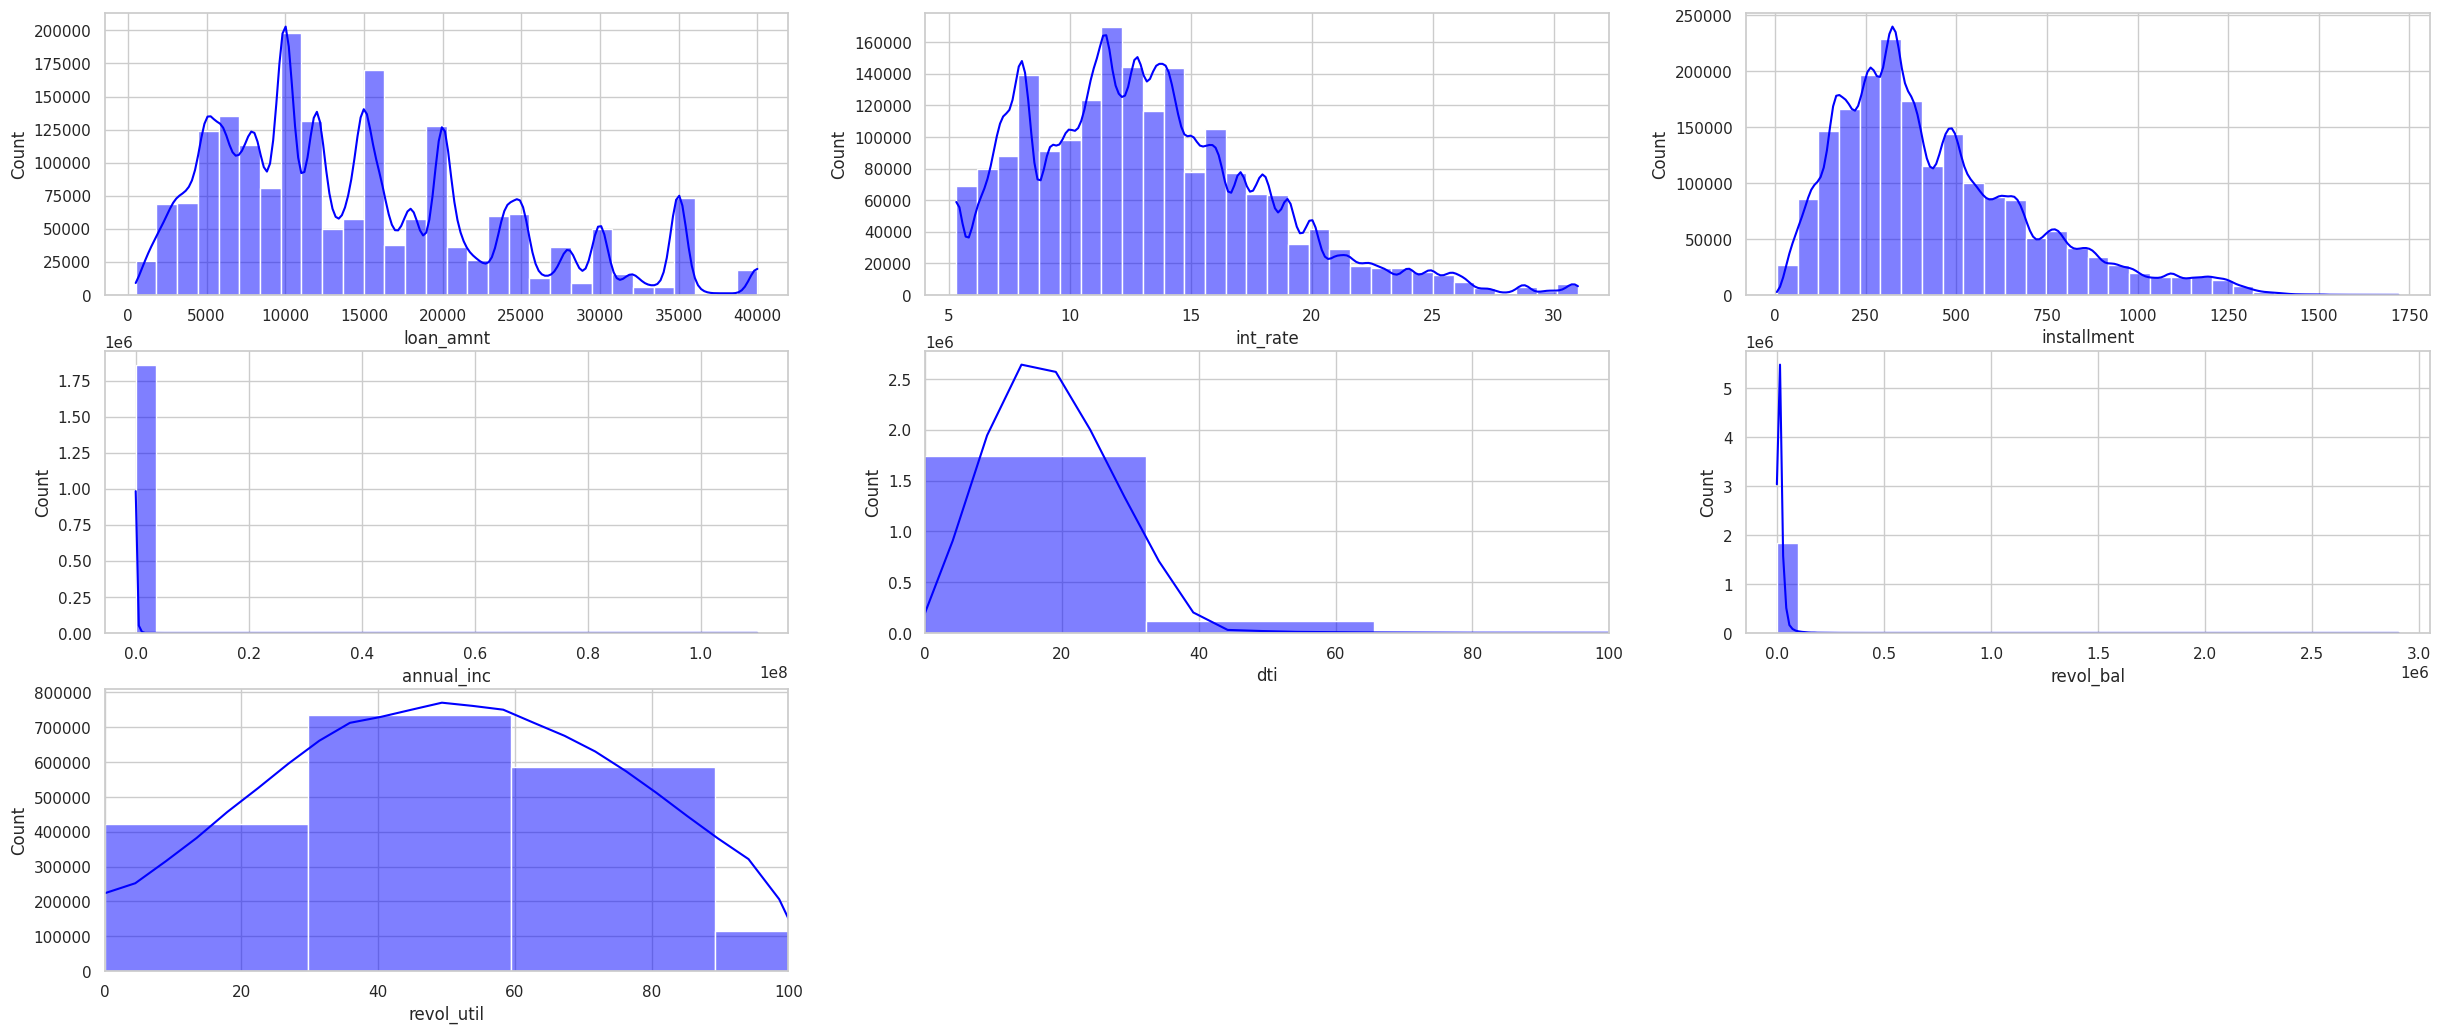

In [ ]:
# @title
plt.figure(figsize=(30, 30))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(7, 3, 1)
sns.histplot(x='loan_amnt', data=df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 2)
sns.histplot(x='int_rate', data=df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 3)
sns.histplot(x='installment', data=df , bins=30, kde=True, color='blue')

plt.subplot(7, 3, 4)
sns.histplot(x='annual_inc', data=df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 5)
sns.histplot(x='dti', data=df, bins=30, kde=True, color='blue')
plt.xlim(0, 100)


plt.subplot(7, 3, 6)
sns.histplot(x='revol_bal', data=df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 7)
sns.histplot(x='revol_util', data=df, bins=30, kde=True, color='blue')
plt.xlim(0, 100)

### Addressing inappropriate values
- DTI: It is the Debt-to-Income ratio, calculated by: all monthly debt payments / gross monthly income. It does not make sense if a DTI ratio is negative, as a person doesn't have a negative monthly debt payments or negative income. It might have been a typing error, so we will remove all negative values in `dti`.

In [237]:
def count_negative_values(data):
  '''
    Count the number of negative values in each feature
  '''
  counts = []
  neg_data = {}
  for i in data.columns:
    if data[i].dtype == float:
      total = (data[i] < 0).sum()
      neg_data[i] = [total]
  neg_df = pd.DataFrame(neg_data).T
  neg_df = neg_df.rename(columns={0: "Number of negative values"})
  return neg_df

In [238]:
neg_df = count_negative_values(df)
neg_df

,Number of negative values
loan_amnt,0
int_rate,0
installment,0
annual_inc,0
dti,2
revol_bal,0
revol_util,0


In [239]:
df = df.drop(df[df['dti'] < 0].index)                     # remove all records with a negative DTI ratio

## Exploratory Data Analysis (EDA)

We visualize the correlation among numerical features.

<ipython-input-240-651235015452>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True, cmap = 'YlGnBu')


<Axes: >

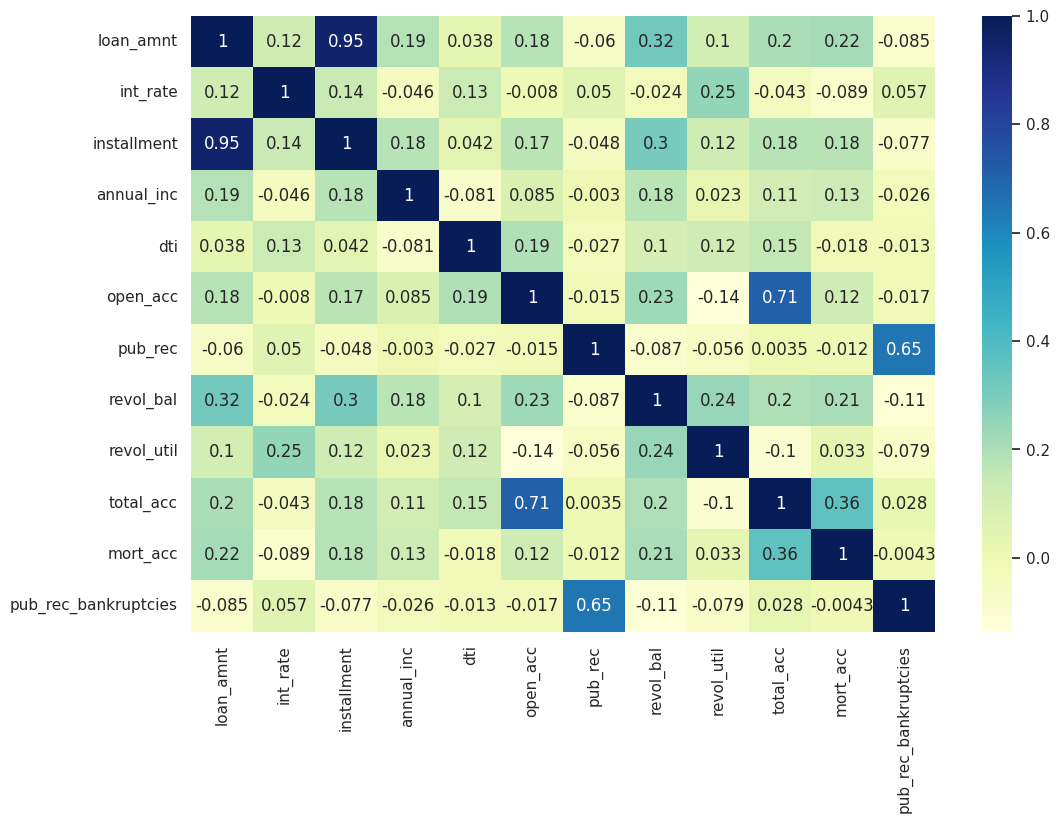

In [240]:
# correlation between features
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot = True, cmap = 'YlGnBu')

We observe that `loan_amnt` and `installment` share a very high correlation, so there may be potential duplicate information between the 2 features. We will take a closer look at them.

## How does each feature affect the target variable?

###`loan_amnt` & `installment`

<Axes: xlabel='installment', ylabel='Count'>

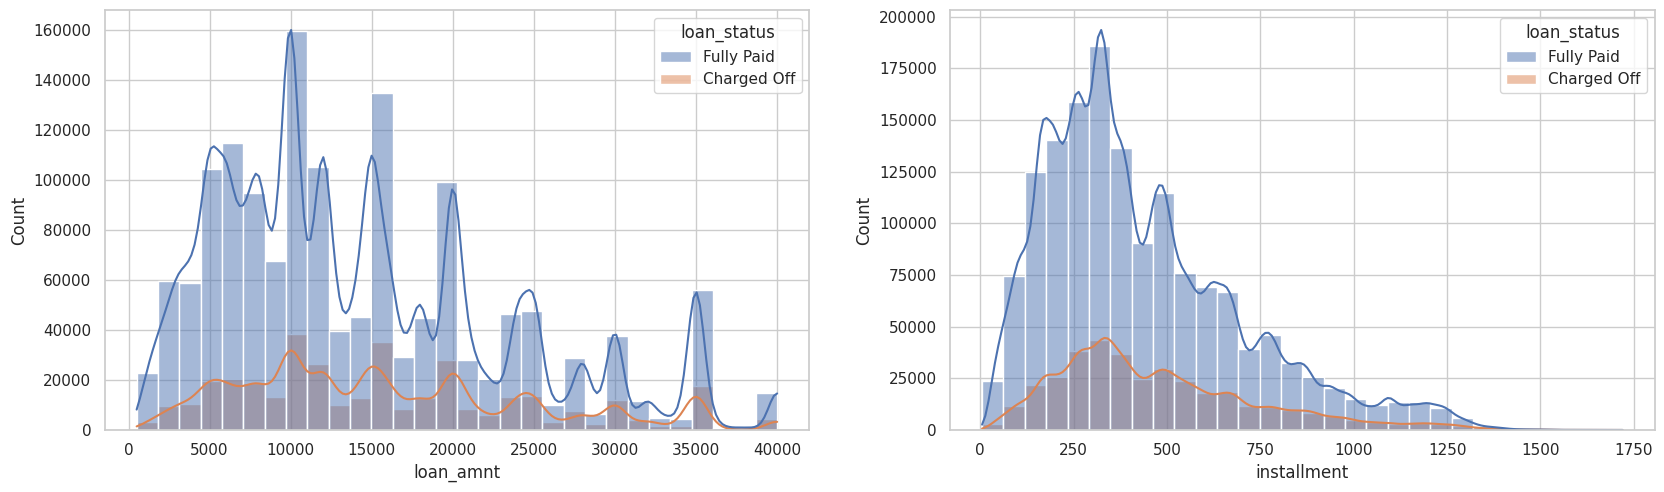

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='loan_amnt', hue='loan_status', data=df, bins=30, kde=True, color='blue')

plt.subplot(2, 2, 2)
sns.histplot(x='installment', hue='loan_status', data=df, bins=30, kde=True, color='blue')

<Axes: xlabel='installment', ylabel='loan_status'>

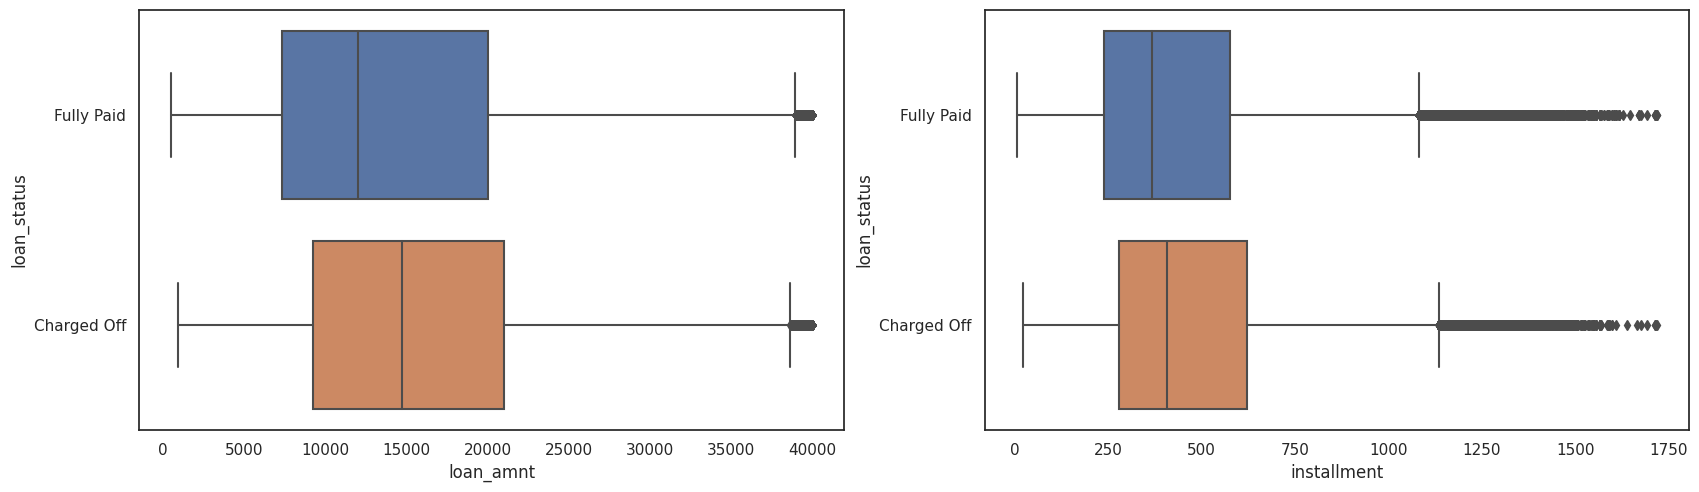

In [ ]:
# @title
plt.figure(figsize=(20, 12))
sns.set(style="white")

plt.subplot(2, 2, 1)
sns.boxplot(x='loan_amnt', y='loan_status', data=df)

plt.subplot(2, 2, 2)
sns.boxplot(x='installment', y='loan_status', data=df)

The average loan amount among all customers is:

In [241]:
loan_amnt_avg = df['loan_amnt'].mean()
print(f"Average Loan Amount: {loan_amnt_avg.round()}")

Average Loan Amount: 14588.0


###`annual_inc` & `int_rate`

We want to see that with the annual income, how many people approved and did not approve for a loan, and the same with interest rate.

<Axes: xlabel='int_rate', ylabel='Count'>

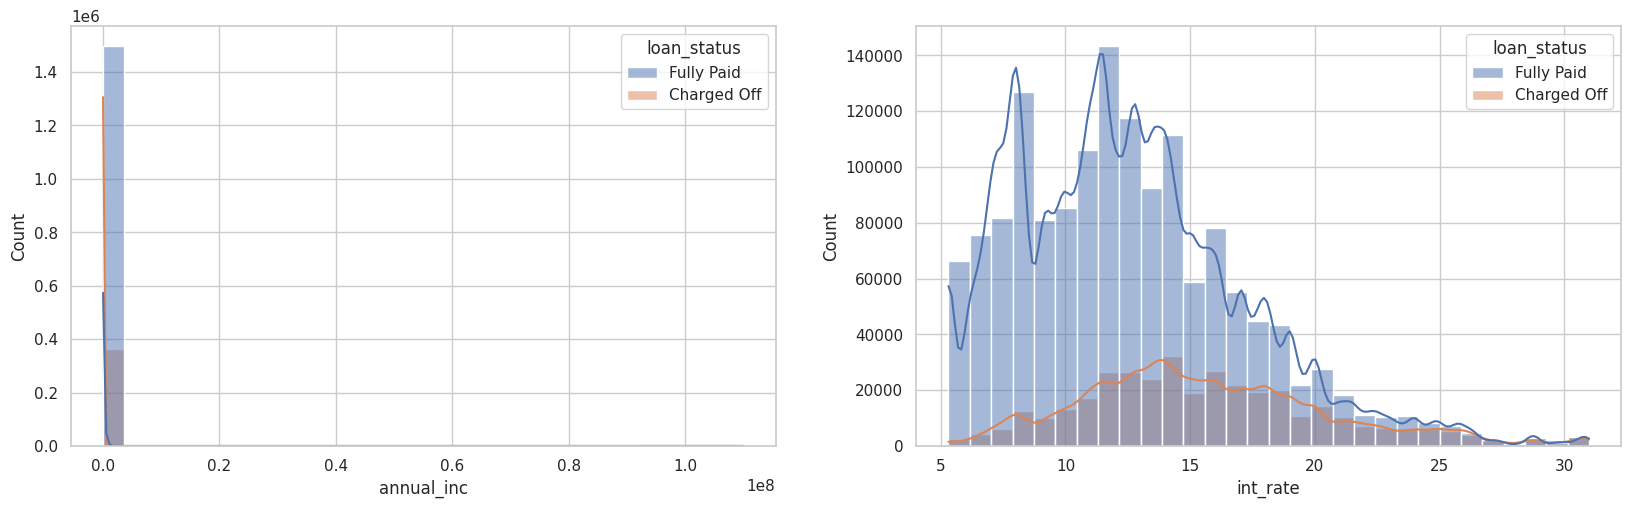

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='annual_inc', hue='loan_status', data=df, bins=30, kde=True, color='blue')

plt.subplot(2, 2, 2)
sns.histplot(x='int_rate', hue='loan_status', data=df, bins=30, kde=True, color='blue')

<Axes: xlabel='int_rate', ylabel='loan_status'>

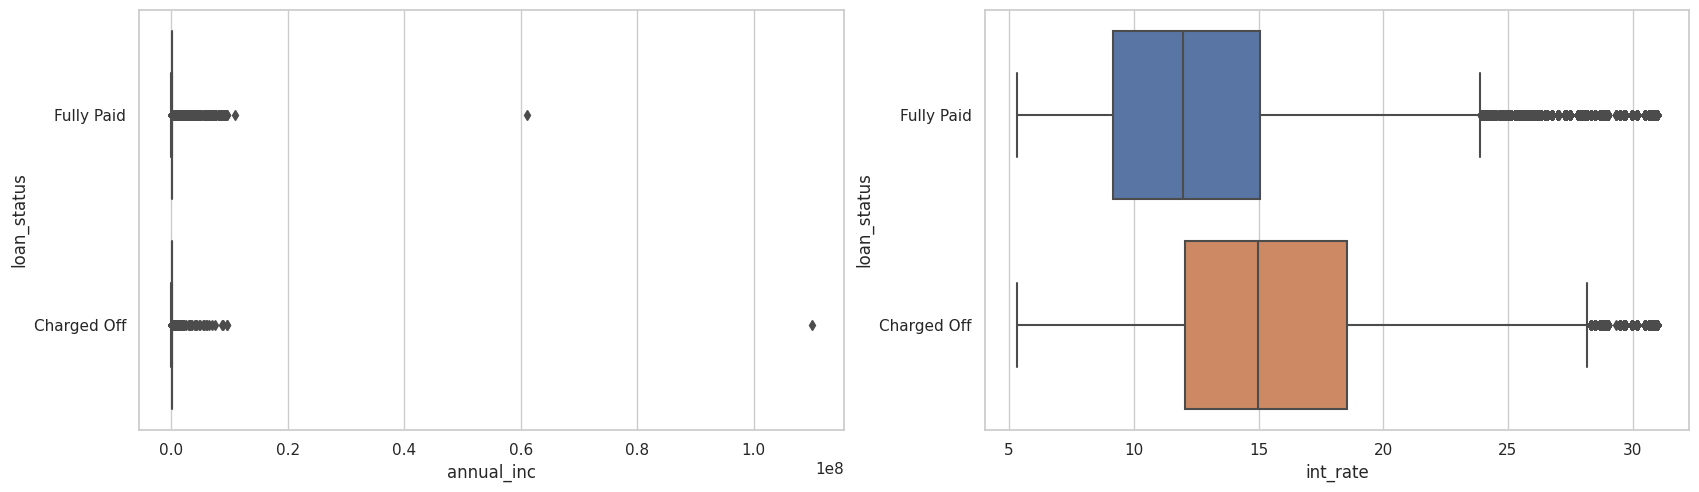

In [ ]:
# @title
plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
sns.boxplot(x='annual_inc', y='loan_status', data=df)

plt.subplot(2, 2, 2)
sns.boxplot(x='int_rate', y='loan_status', data=df)

We want to visualize some outliers in the annual income.

In [242]:
Q1_annual_inc = np.percentile(df['annual_inc'], 25)           # 25th percentile of annual_inc
Q3_annual_inc = np.percentile(df['annual_inc'], 75)           # 75th percentile of annual_inc

IQR_annual_inc = Q3_annual_inc - Q1_annual_inc                # IQR of annual_inc

lower_bound_annual_inc = Q1_annual_inc - 1.5 * IQR_annual_inc
upper_bound_annual_inc = Q3_annual_inc + 1.5 * IQR_annual_inc

outliers_annual_inc = df[(df['annual_inc'] < lower_bound_annual_inc) | (df['annual_inc'] > upper_bound_annual_inc)]
outliers_annual_inc.shape

(87826, 26)

We observe there are still too many outliers in `annual_inc` (87826). If we decide to remove those outliers, we might lose too much information. Furthermore, we can visualize there are some extreme outliers, and the traditional IQR method may not be able to capture them. We apply an alternative, more flexible IQR method called Tukey's Fence.

In [244]:
def tukey_fence(data, col, k):
  '''
    Detect any outliers in each feature column
    using Tukey's Fence method (flexible IQR)

    Parameters:
      data: DataFrame
      col: Series (column)
      k: float

    Purpose:
      k is a flexible constant which allows to
      modify the range of lower and upper bound, which
      is more robust to skewed distributions and outliers

    Returns: DataFrame
  '''
  Q1 = np.percentile(data[col], 25)
  Q3 = np.percentile(data[col], 75)
  IQR = Q3 - Q1
  lower_bound = Q1 - k * IQR
  upper_bound = Q3 + k * IQR
  outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
  return outliers

Here I choose `k=9` of preference. Usually the k value for Tukey fence is 3 to detect "far out" outliers. But we can see from the box plots that there are people who earn lot, lot more than the average so fixing the "fence" would help separating those extreme outliers.

In [245]:
outliers_annual_inc = tukey_fence(df[:], col="annual_inc", k=9)     # typical k value for Tukey's Fence to detect "far out" data points

In [246]:
print(outliers_annual_inc.shape)
print(f"Minimum annual income of those outliers: {outliers_annual_inc['annual_inc'].min()}")

(2729, 26)
Minimum annual income of those outliers: 506183.0


The minimum of these "very far out" outliers is $506,183 which is a lot, so this will be a threshold, and later on we will consider removing any records with an annual income equal to or above this threshold.

#### Insight
In the aspect of lenders, they consider an annual income of several times higher than the loan amount to mitigate the risk of the borrower being charged off. A threshold of an annual income of 3 times higher than the loan amount should be reasonable. Thus we want to learn that how many people in this range can afford a loan.

In [247]:
annual_inc_df = df[(df['annual_inc'] >= 3 * loan_amnt_avg) & (df['annual_inc'] <= 200000)]    # set the range to a more reasonable annual income range

[Text(0.5, 1.0, 'Loan Status of Annual Income 3 times higher than the average loan amount')]

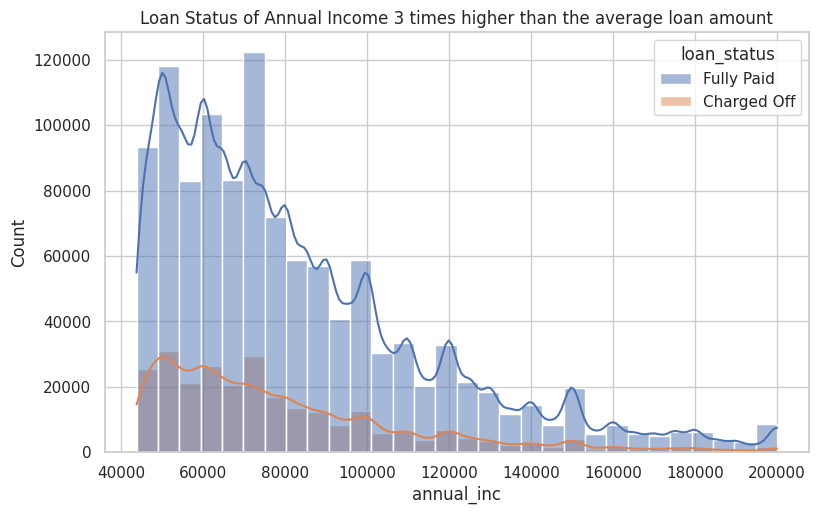

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='annual_inc', hue='loan_status', data=annual_inc_df, bins=30, kde=True, color='blue').set(title='Loan Status of Annual Income 3 times higher than the average loan amount')

###`grade` & `sub_grade`

`grade`: the assigned loan grade. Each grade corresponds with a certain level of risk while lending to that corresponded person.

`sub_grade`: the assigned loan sub grade. Each sub grade corresponds with a certain level of risk.

<ipython-input-40-18014df90fcd>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, 'B2'),
 Text(1, 0, 'C4'),
 Text(2, 0, 'C5'),
 Text(3, 0, 'C1'),
 Text(4, 0, 'B5'),
 Text(5, 0, 'A4'),
 Text(6, 0, 'E1'),
 Text(7, 0, 'F2'),
 Text(8, 0, 'C3'),
 Text(9, 0, 'B1'),
 Text(10, 0, 'D1'),
 Text(11, 0, 'A1'),
 Text(12, 0, 'B3'),
 Text(13, 0, 'B4'),
 Text(14, 0, 'C2'),
 Text(15, 0, 'D2'),
 Text(16, 0, 'A3'),
 Text(17, 0, 'A5'),
 Text(18, 0, 'D5'),
 Text(19, 0, 'A2'),
 Text(20, 0, 'E4'),
 Text(21, 0, 'D3'),
 Text(22, 0, 'D4'),
 Text(23, 0, 'F3'),
 Text(24, 0, 'E3'),
 Text(25, 0, 'F4'),
 Text(26, 0, 'F1'),
 Text(27, 0, 'E5'),
 Text(28, 0, 'G4'),
 Text(29, 0, 'E2'),
 Text(30, 0, 'G3'),
 Text(31, 0, 'G2'),
 Text(32, 0, 'G1'),
 Text(33, 0, 'F5'),
 Text(34, 0, 'G5')]

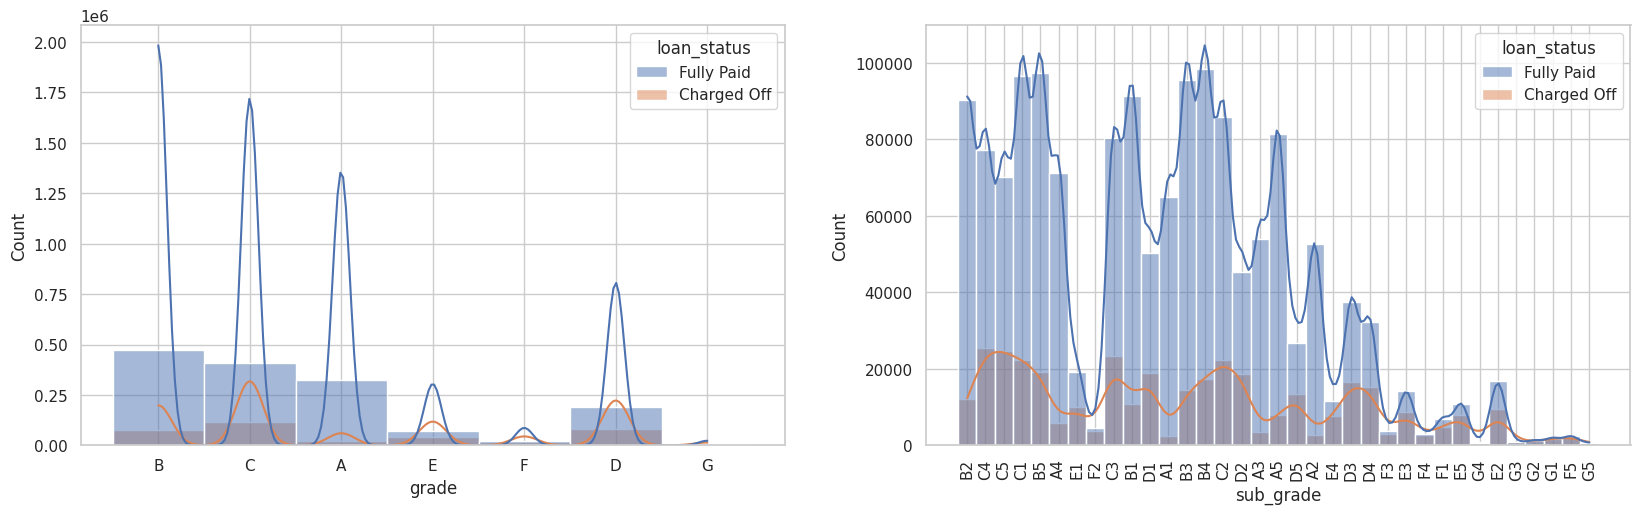

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='grade', hue='loan_status', data=df, bins=30, kde=True, color='blue')

plt.subplot(2, 2, 2)
g = sns.histplot(x='sub_grade', hue='loan_status', data=df, bins=30, kde=True, color='blue')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

We observe that there are not many people at grade F and G that pay back, and that's illustrated in more detail in the `sub_grade` plot.

<ipython-input-41-dafb3f7ad454>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, 'F2'),
 Text(1, 0, 'F3'),
 Text(2, 0, 'F4'),
 Text(3, 0, 'F1'),
 Text(4, 0, 'G4'),
 Text(5, 0, 'G3'),
 Text(6, 0, 'G2'),
 Text(7, 0, 'G1'),
 Text(8, 0, 'F5'),
 Text(9, 0, 'G5')]

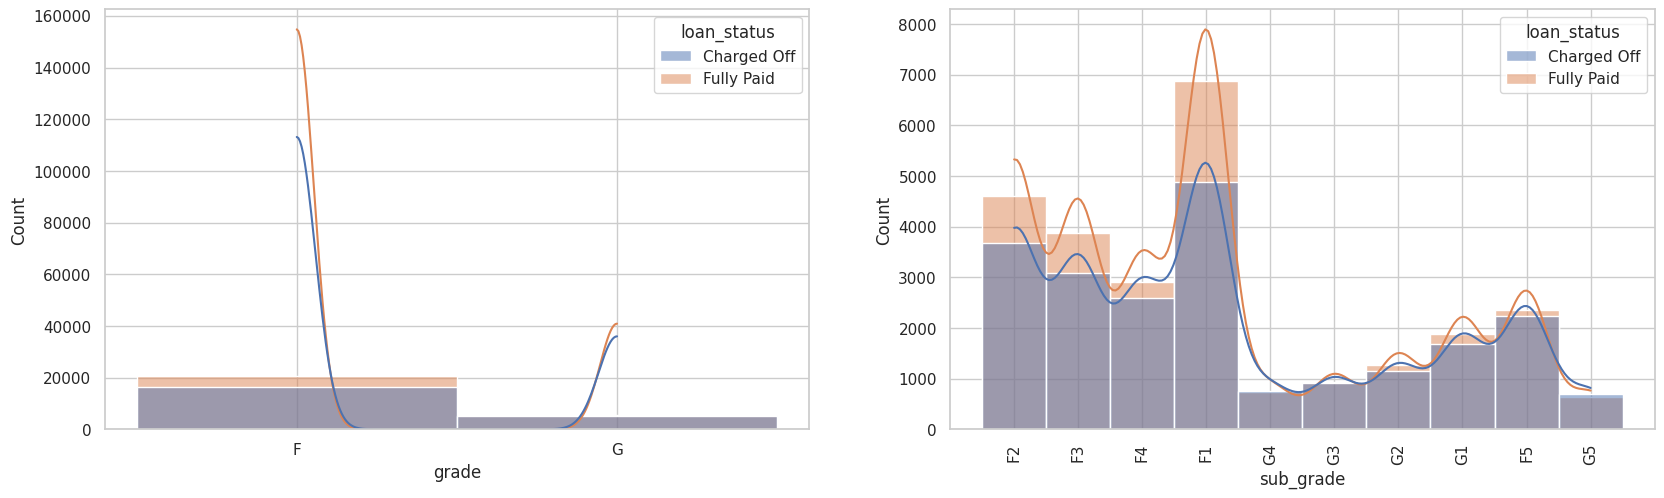

In [ ]:
grade_df = df[(df['grade'] == 'F') | (df['grade'] == 'G')]

# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='grade', hue='loan_status', data=grade_df, bins=30, kde=True, color='blue')

plt.subplot(2, 2, 2)
g = sns.histplot(x='sub_grade', hue='loan_status', data=grade_df, bins=30, kde=True, color='blue')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

###`home_ownership` & `verification_status` & `term` & `purpose`

`home_ownership`: The home ownership status provided by the borrower.

`verification_status`: indicates if the income was verified by Loaning Club.

`term`: the number of payments on the loan, depending on the term of the loan (36 or 60 months).

`purpose`: the category provided by the borrower for the loan request.

What are the possible values for each of these features?

In [248]:
df['home_ownership'].value_counts()

MORTGAGE    918026
RENT        735358
OWN         205578
ANY           1174
OTHER          144
NONE            49
Name: home_ownership, dtype: int64

In [171]:
df['verification_status'].value_counts()

Source Verified    734067
Not Verified       588360
Verified           537902
Name: verification_status, dtype: int64

In [172]:
df['term'].value_counts()

 36 months    1393298
 60 months     467031
Name: term, dtype: int64

In [173]:
df['purpose'].value_counts()

debt_consolidation    1063457
credit_card            412844
home_improvement       123861
other                  113589
major_purchase          41750
medical                 22578
small_business          20515
car                     20215
vacation                13333
moving                  13203
house                   11099
wedding                  2298
renewable_energy         1260
educational               327
Name: purpose, dtype: int64

[Text(0, 0, 'credit_card'),
 Text(1, 0, 'car'),
 Text(2, 0, 'small_business'),
 Text(3, 0, 'other'),
 Text(4, 0, 'wedding'),
 Text(5, 0, 'debt_consolidation'),
 Text(6, 0, 'home_improvement'),
 Text(7, 0, 'major_purchase'),
 Text(8, 0, 'medical'),
 Text(9, 0, 'moving'),
 Text(10, 0, 'vacation'),
 Text(11, 0, 'house'),
 Text(12, 0, 'renewable_energy'),
 Text(13, 0, 'educational')]

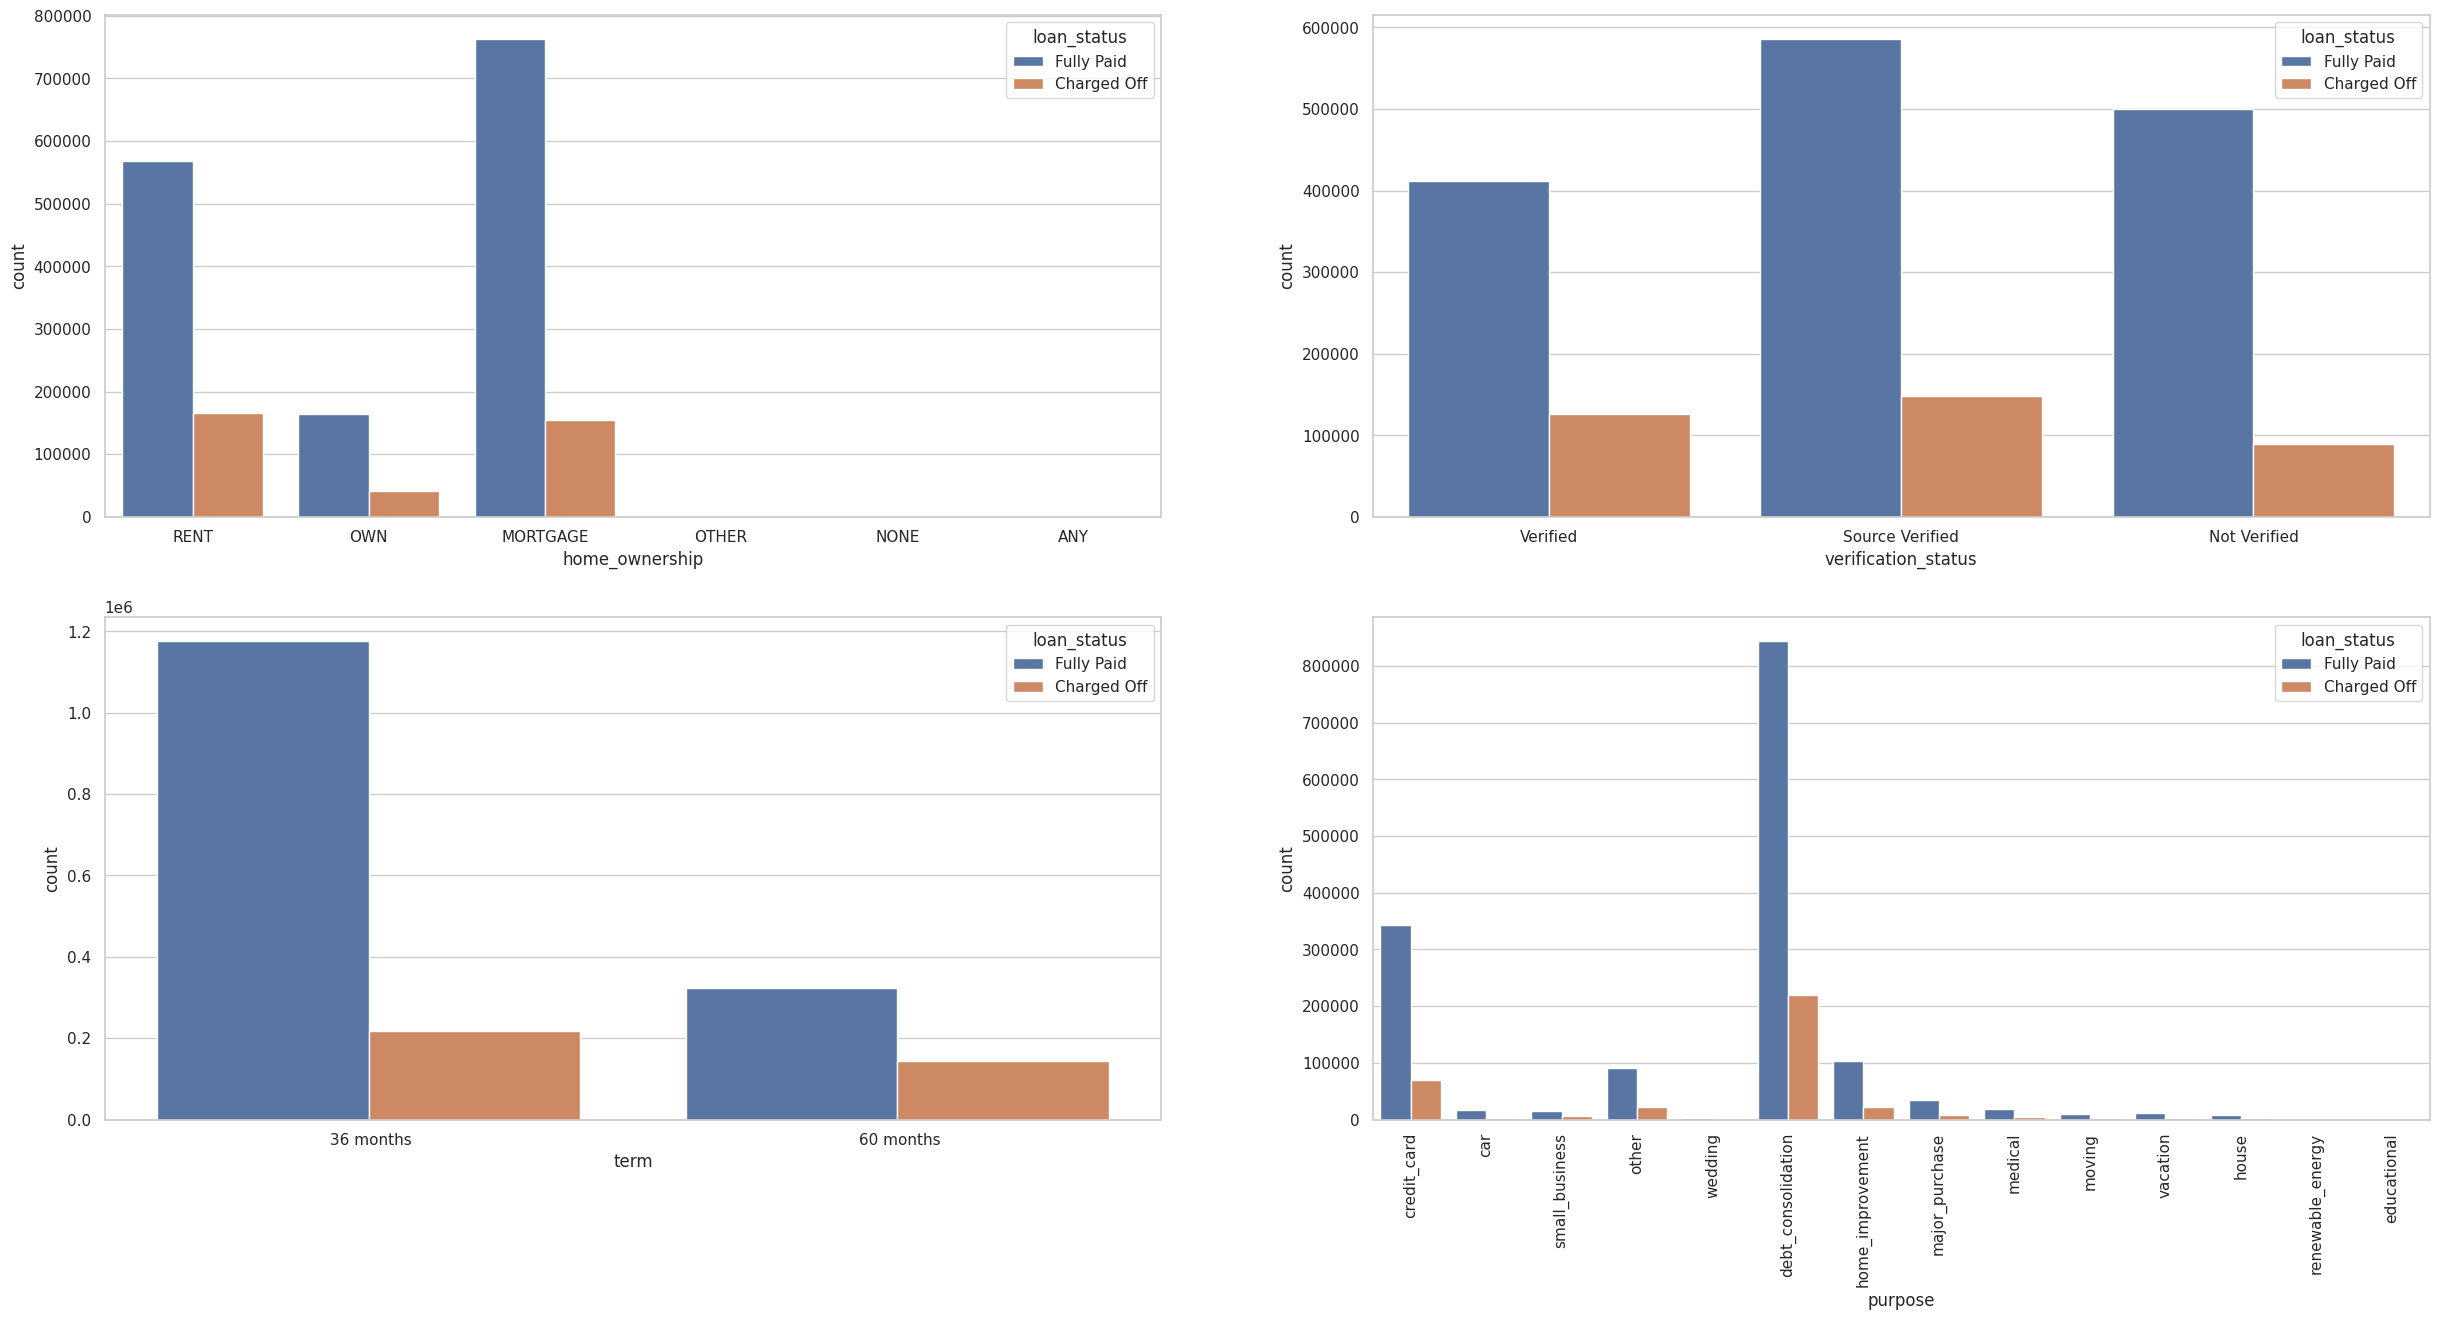

In [ ]:
# @title
plt.figure(figsize=(30, 30))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(4, 2, 1)
sns.countplot(x='home_ownership', hue='loan_status', data=df)

plt.subplot(4, 2, 2)
sns.countplot(x='verification_status', hue='loan_status', data=df)

plt.subplot(4, 2, 3)
sns.countplot(x='term', hue='loan_status', data=df)

plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', hue='loan_status', data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

Most people who afford the loan was those who own mortgage, have a verified source of income, in a 36-month loan term, and have a purpose of debt consolidation.

###`dti`

`dti`: the debt-to-income ratio.

DTI = (all monthly debt payment) / (gross monthly income)

=> the lower DTI, the more positive one's credit score is => more likely to qualify for a loan.

<Axes: xlabel='dti', ylabel='Count'>

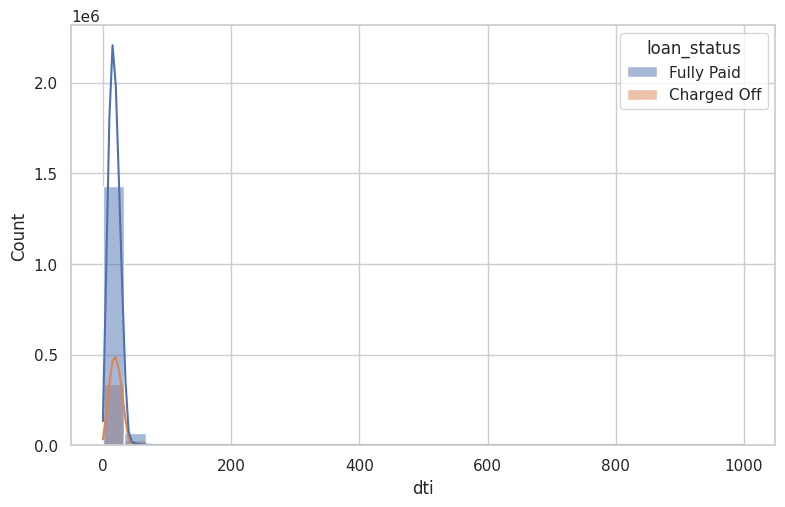

In [174]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='dti', hue='loan_status', data=df, bins=30, kde=True, color='blue')

In [175]:
print("DTI max: ",df['dti'].max())

DTI max:  999.0


<Axes: xlabel='dti', ylabel='loan_status'>

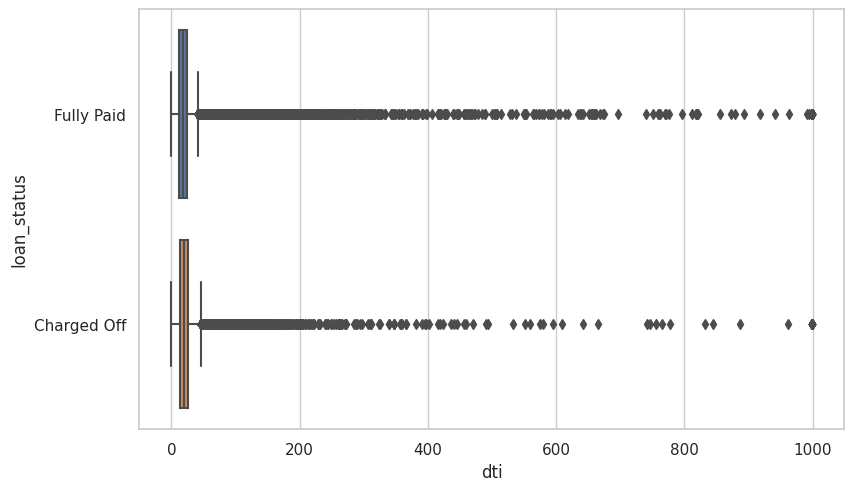

In [176]:
# @title
plt.figure(figsize=(20, 12))
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.boxplot(x="dti", y="loan_status", data=df)

We observe that there are a lot of outliers in `dti`. Also, the whiskers are really narrow, so we want to stretch them out a bit to capture less outliers. Let's apply Tukey's Fence again to `dti`.

In [249]:
dti_outliers = tukey_fence(df[:], col='dti', k=9)

In [250]:
print(f"Number of outliers in DTI: {dti_outliers.shape[0]}")

dti_threshold = dti_outliers['dti'].min()
print(f"Minimum value of all DTI's outliers: {dti_threshold}")

Number of outliers in DTI: 913
Minimum value of all DTI's outliers: 136.35


#### Insight
By convention, a DTI of less than or equal to 43% might be a good threshold that all borrowers with a DTI lower than this threshold are more likely to pay off the loan.

In [251]:
dti_df = df[(df['dti'] <= 43)]

[Text(0.5, 1.0, 'Loan Status of DTI <= 43%')]

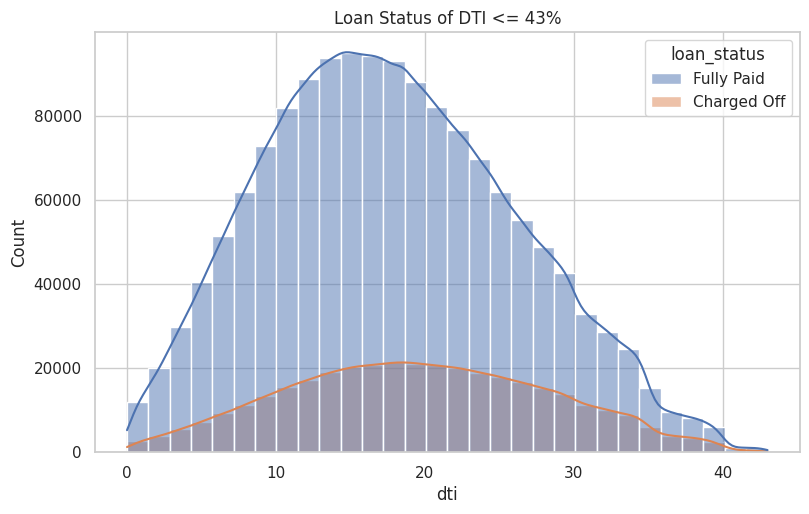

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='dti', hue='loan_status', data=dti_df, bins=30, kde=True, color='blue').set(title="Loan Status of DTI <= 43%")

We observe that with the DTI of around 10-20%, the loan is more likely to be paid, while a lower or higher DTI from this range results in a higher chance of unpaid loan.

###`revol_bal` & `revol_util`


`revol_bal`: the total revolving balance

`revol_util`: the revolving utilization rate

<Axes: xlabel='revol_util', ylabel='Count'>

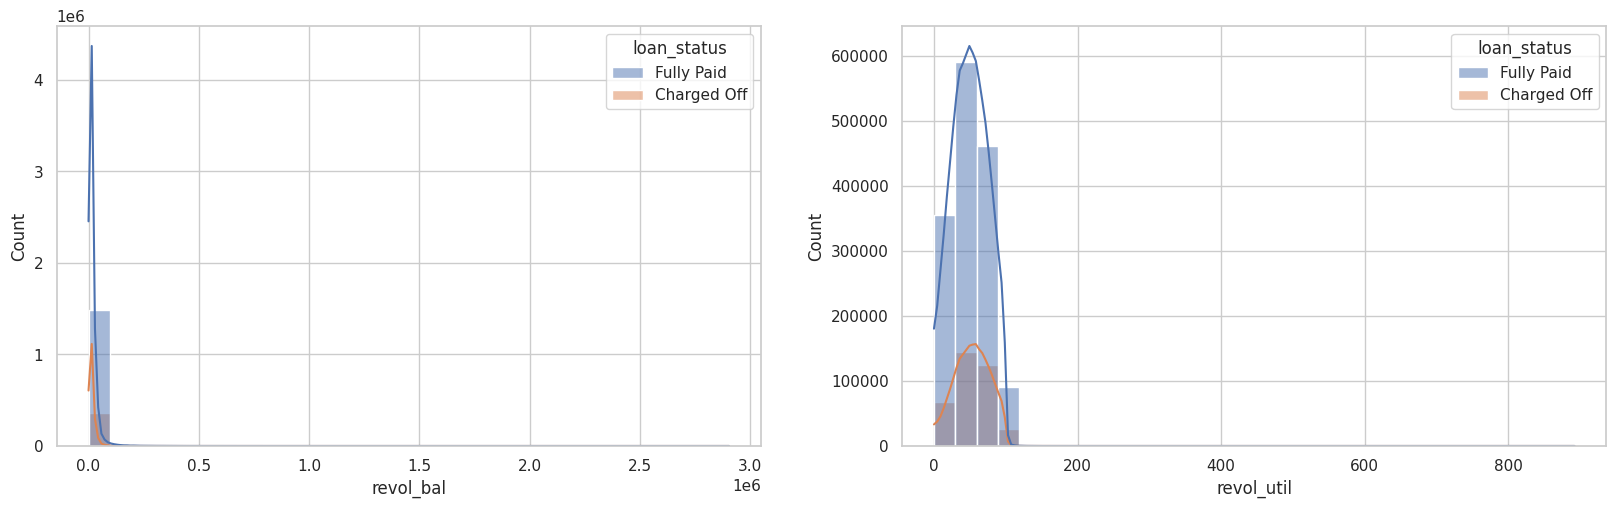

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='revol_bal', hue='loan_status', data=df, bins=30, kde=True, color='blue')

plt.subplot(2, 2, 2)
sns.histplot(x='revol_util', hue='loan_status', data=df, bins=30, kde=True, color='blue')

<Axes: xlabel='revol_util', ylabel='loan_status'>

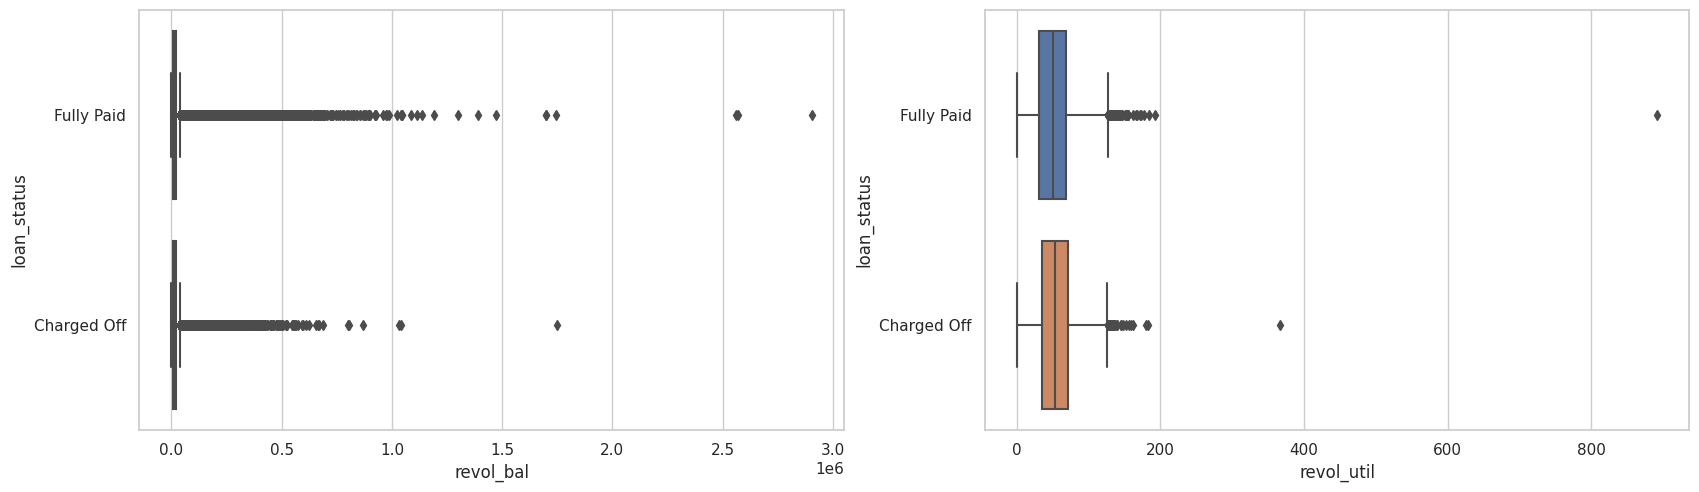

In [ ]:
# @title
plt.figure(figsize=(20, 12))
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.boxplot(x="revol_bal", y="loan_status", data=df)

plt.subplot(2, 2, 2)
sns.boxplot(x='revol_util', y='loan_status', data=df)

There are extreme outliers (outside range of `[Q1-1.5*IQR, Q3+1.5*IQR]`) in `revol_bal` and `revol_util`, so again we apply Tukey's Fence again.

In [252]:
revol_bal_outliers = tukey_fence(df[:], col="revol_bal", k=9)
revol_util_outliers = tukey_fence(df[:], col="revol_util", k=6)

In [253]:
print(f"Number of extreme outliers in revol_bal: {revol_bal_outliers.shape[0]}")
print(f"Number of extreme outliers in revol_util: {revol_util_outliers.shape[0]}")

Number of extreme outliers in revol_bal: 7997
Number of extreme outliers in revol_util: 2


We capture all 2 extreme outliers in `revol_util`

In [254]:
revol_bal_threshold = revol_bal_outliers['revol_bal'].min()
print(revol_bal_threshold)

145138.0


#### Insight
By convention, a revolving utilization rate of less than or equal to 30% is a good threshold that all borrowers with a `revol_util` rate below this threshold have a more positive credit score and more likely to pay back the loan.

In [255]:
revol_util_df = df[(df['revol_util'] <= 30)]

[Text(0.5, 1.0, 'Loan Status with revol utilization rate <= 30%')]

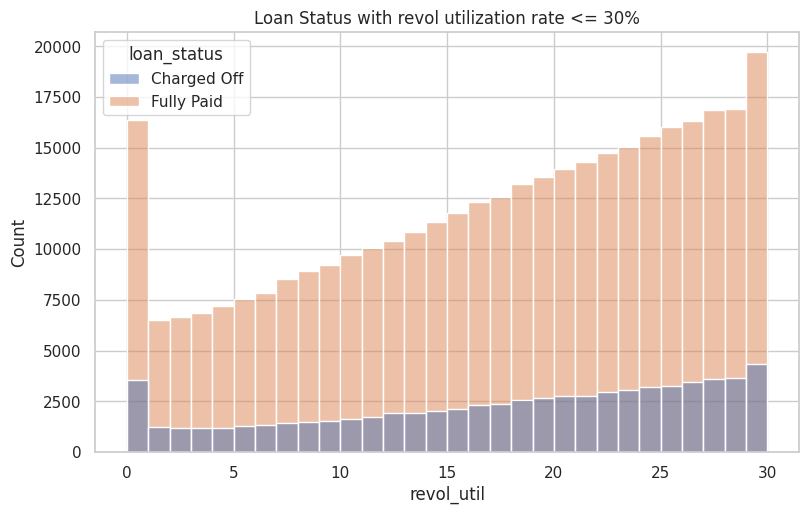

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='revol_util', hue='loan_status', data=revol_util_df, bins=30, color='blue').set(title="Loan Status with revol utilization rate <= 30%")

We observe that the lower the revolving utilization rate, the fewer people pay back the loan.

###`total_acc` & `open_acc`

`total_acc`: the total number of credit lines currently in borrower's credit file

`open_acc`: the number of open credit lines in the borrower's credit file

<Axes: xlabel='open_acc', ylabel='Count'>

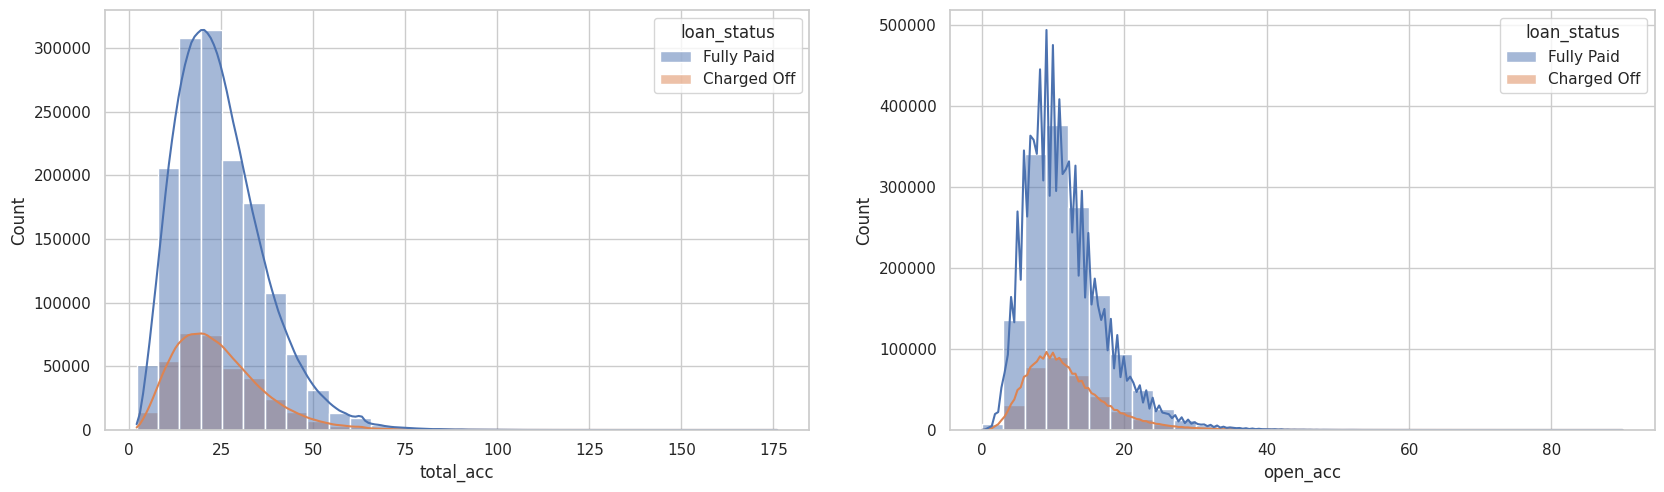

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='total_acc', hue='loan_status', data=df, bins=30, kde=True, color='blue')

plt.subplot(2, 2, 2)
sns.histplot(x='open_acc', hue='loan_status', data=df, bins=30, kde=True, color='blue')

<Axes: xlabel='open_acc', ylabel='loan_status'>

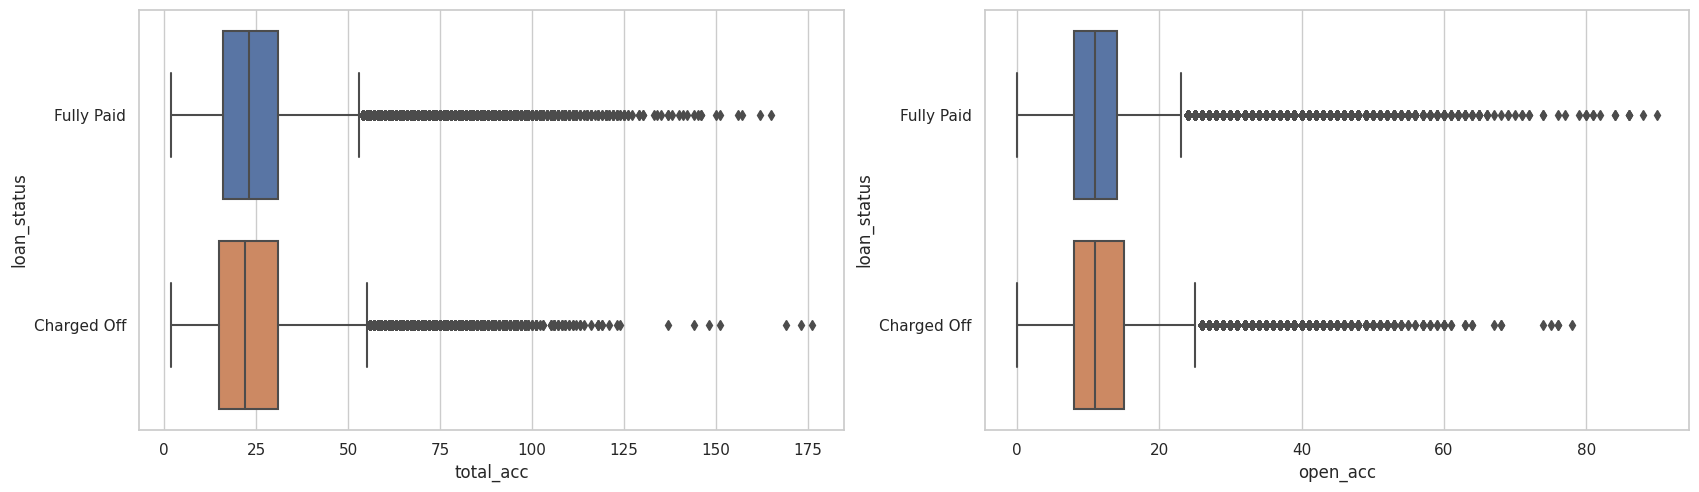

In [ ]:
# @title
plt.figure(figsize=(20, 12))
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.boxplot(x="total_acc", y="loan_status", data=df)

plt.subplot(2, 2, 2)
sns.boxplot(x="open_acc", y="loan_status", data=df)

Again, there are extreme outliers so we apply Tukey's Fence to detect them.

In [266]:
total_acc_outliers = tukey_fence(df[:], col="total_acc", k=4)         # decide the k value based on visualization on the histogram
open_acc_outliers = tukey_fence(df[:], col="open_acc", k=4)

In [267]:
print(f"Number of outliers in total_acc: {total_acc_outliers.shape[0]}")
print(f"Number of outliers in open_acc: {open_acc_outliers.shape[0]}")

Number of outliers in total_acc: 636
Number of outliers in open_acc: 2857


In [268]:
total_acc_threshold = total_acc_outliers['total_acc'].min()
open_acc_threshold = open_acc_outliers['open_acc'].min()

print(f"total_acc outlier minimum: {total_acc_threshold}")
print(f"open_acc outlier minimum: {open_acc_threshold}")

total_acc outlier minimum: 92
open_acc outlier minimum: 39


#### `pub_rec` & `pub_rec_bankruptcies`

`pub_rec`: the number of derogatory public records

`pub_rec_bankruptcies`: the number of public record bankruptcies

In [269]:
print(f"Maximum number of public derogatory record: {df['pub_rec'].max()}")
print(f"Maximum number of public record bankruptcies: {df['pub_rec_bankruptcies'].max()}")

Maximum number of public derogatory record: 86
Maximum number of public record bankruptcies: 12


We should realize that any borrowers with a number of public derogatory record or public record bankruptcies more than 1 should be considered "red flags", as this significantly affects their credit score and ability to pay off loan debts since they already go bankrupt or have negative credit behavior.

Therefore, we only need to consider binary value of `pub_rec` and `pub_rec_bankruptcies`: No records (0), or existing records (1). This now turn into a categorical variable.

<Axes: xlabel='pub_rec_bankruptcies', ylabel='Count'>

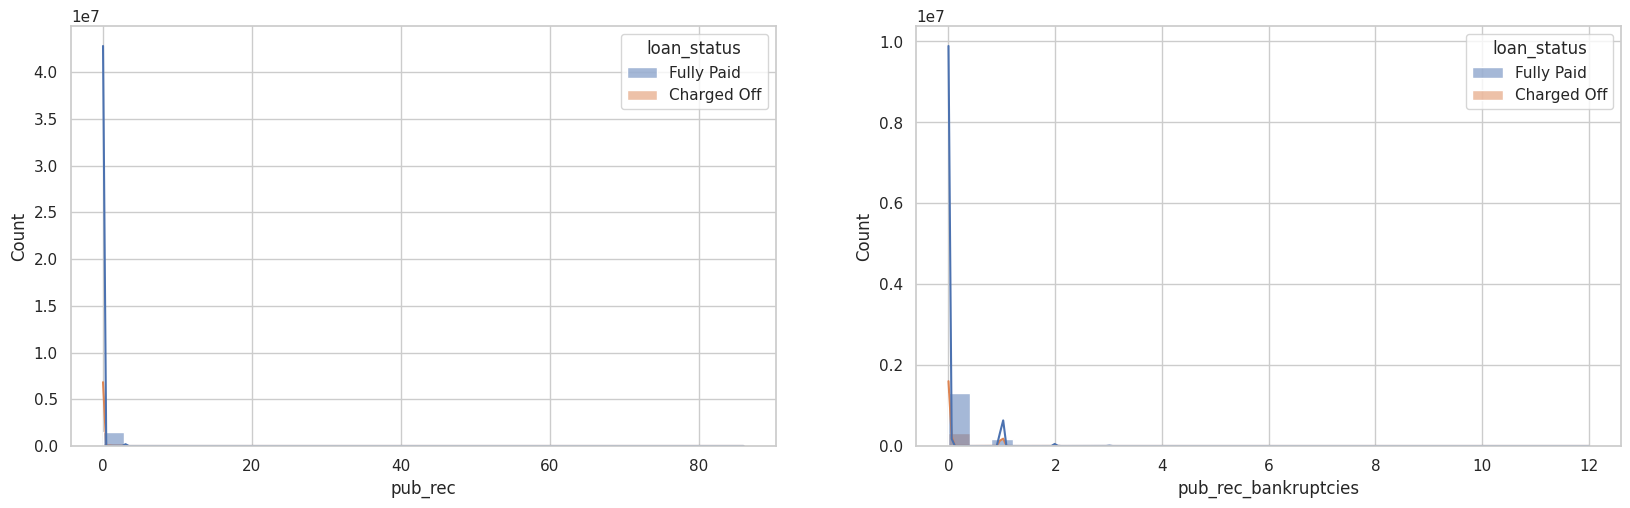

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='pub_rec', hue='loan_status', data=df, bins=30, kde=True, color='blue')

plt.subplot(2, 2, 2)
sns.histplot(x='pub_rec_bankruptcies', hue='loan_status', data=df, bins=30, kde=True, color='blue')

<Axes: xlabel='pub_rec_bankruptcies', ylabel='loan_status'>

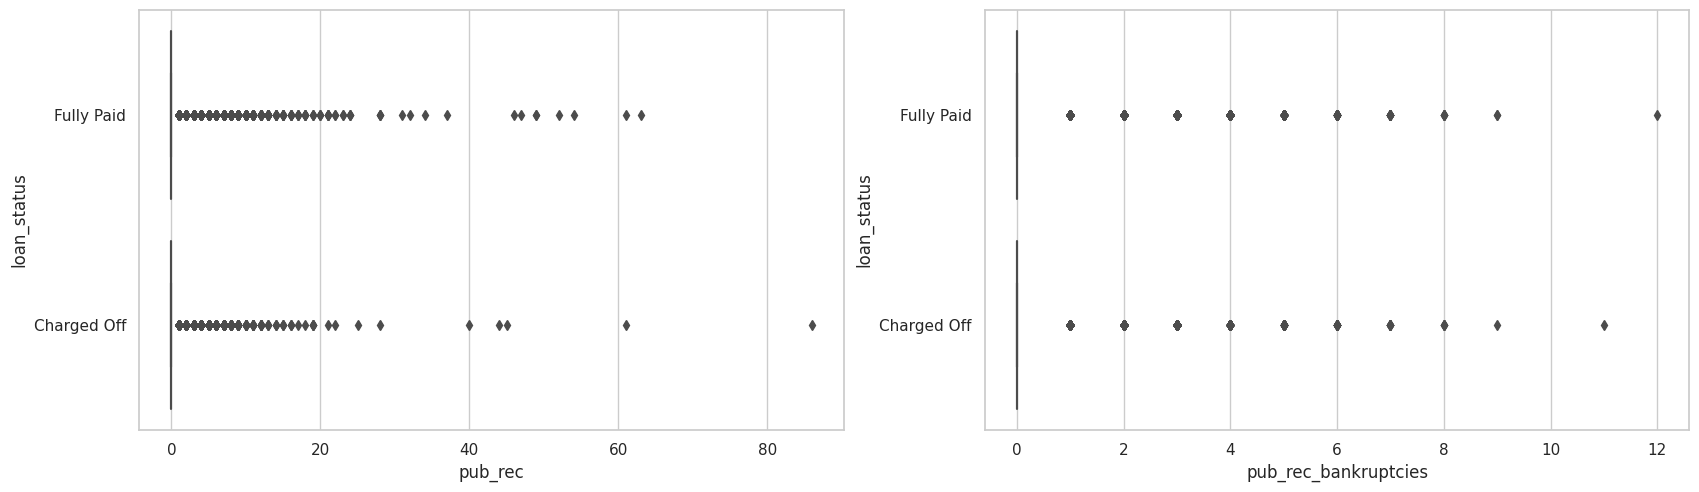

In [190]:
# @title
plt.figure(figsize=(20, 12))
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.boxplot(x="pub_rec", y="loan_status", data=df)

plt.subplot(2, 2, 2)
sns.boxplot(x="pub_rec_bankruptcies", y="loan_status", data=df)

Since most people have 0 public derogatory records and no public record bankruptcies, this is a positive credit behavior among all borrowers.

Furthermore, that results in a mean, median, Q1, Q3, and IQR are all 0, so it does not make sense that we can apply Tukey's Fence here.

In [205]:
print(f"Average pub_rec: {df['pub_rec'].mean().round()}")
print(f"Average pub_rec_bankruptcies: {df['pub_rec_bankruptcies'].mean().round()}")

Average pub_rec: 0.0
Average pub_rec_bankruptcies: 0.0


#### Insight
We observe that most borrowers has 0 derogatory public records, and 0 public record bankruptcies. We notice that borrowers with more than 1 public record bankruptcies should be considered "red flags": this significantly affects their credit score and the ability to qualify for future loans.

In [189]:
pub_rec_bankrupt_df = df[(df['pub_rec_bankruptcies'] > 1)]

[Text(0.5, 1.0, 'Loan Status of More than 1 Public Record Bankruptcies')]

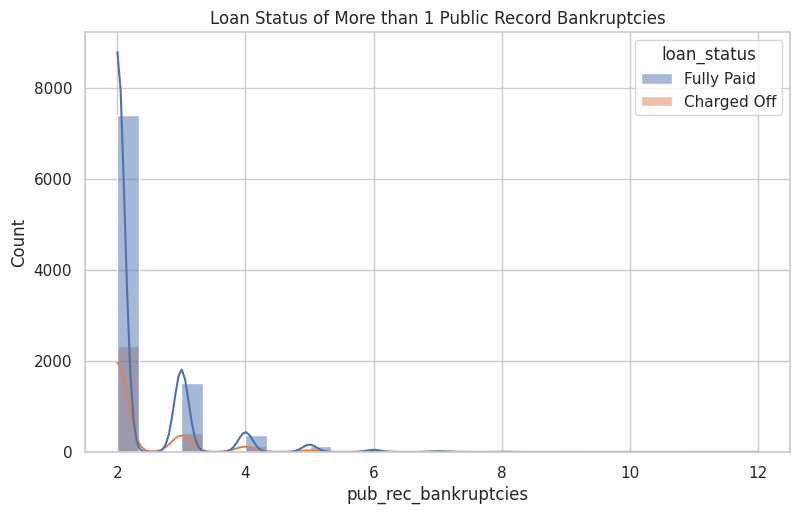

In [ ]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x='pub_rec_bankruptcies', hue='loan_status', data=pub_rec_bankrupt_df, bins=30, kde=True, color='blue').set(title="Loan Status of More than 1 Public Record Bankruptcies")

#### `emp_title` & `emp_length`

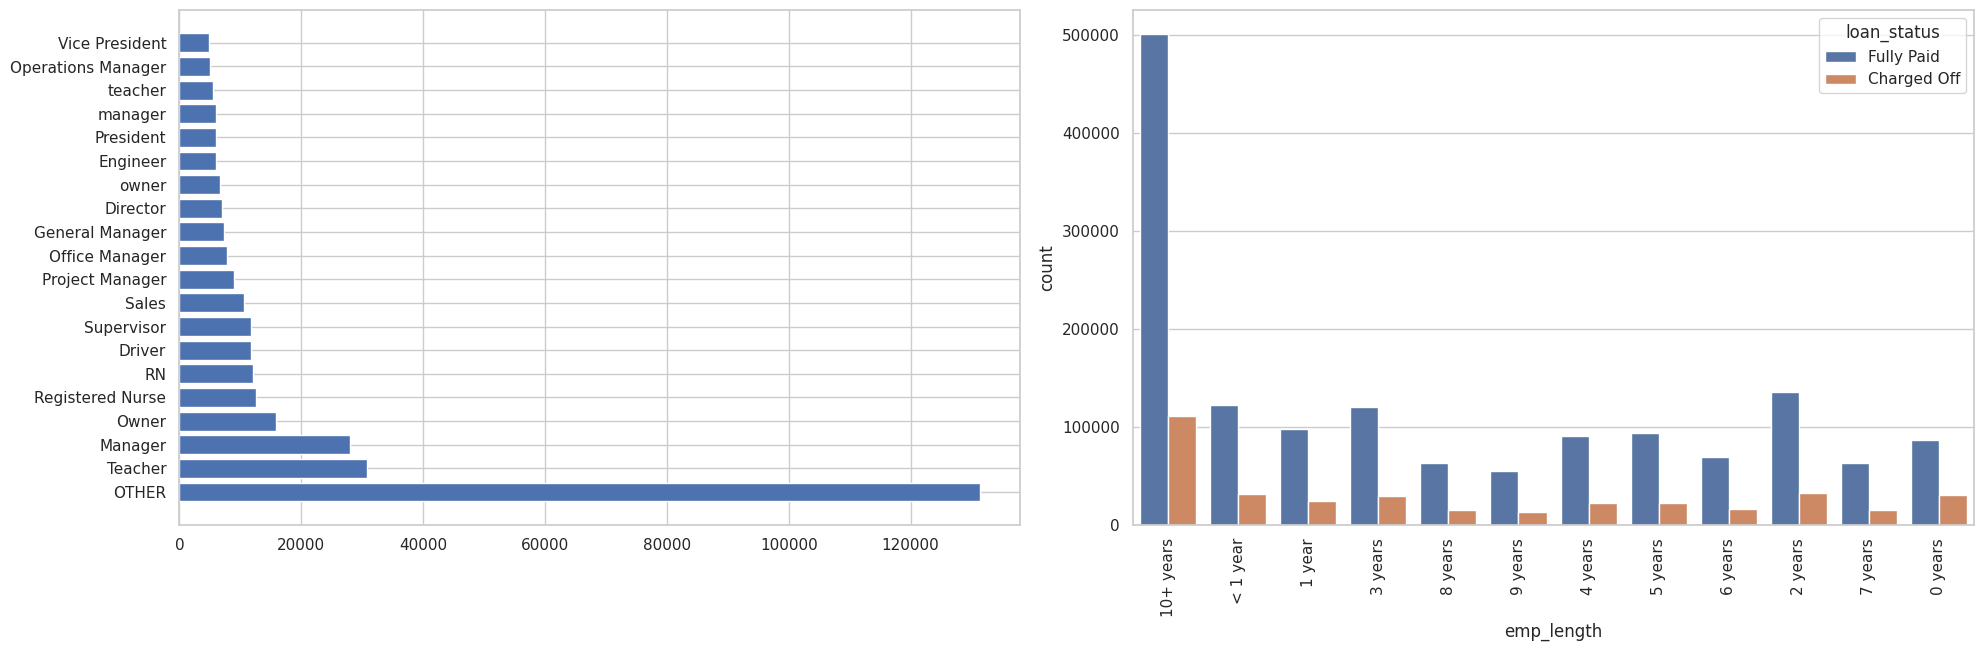

In [283]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
plt.barh(df['emp_title'].value_counts()[:20].index, df['emp_title'].value_counts()[:20])

plt.subplot(2, 2, 2)
g = sns.countplot(x='emp_length', hue='loan_status', data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

plt.tight_layout()

It shows that teachers and managers are more likely to pay off the loan as they are stable jobs, while obviously people who have been working for more than 10 years can pay off the loan debts easily.

#### `issue_d` & `earliest_cr_line`

As the date in those features is in "YYYY-MM-DD" format, we should convert them to "YYYY", as it is not that important to consider each month or each day into the ability to pay off the loan.

In [290]:
df['issue_d'] = df['issue_d'].dt.year
df['earliest_cr_line'] = df['earliest_cr_line'].dt.year

<Axes: xlabel='earliest_cr_line', ylabel='count'>

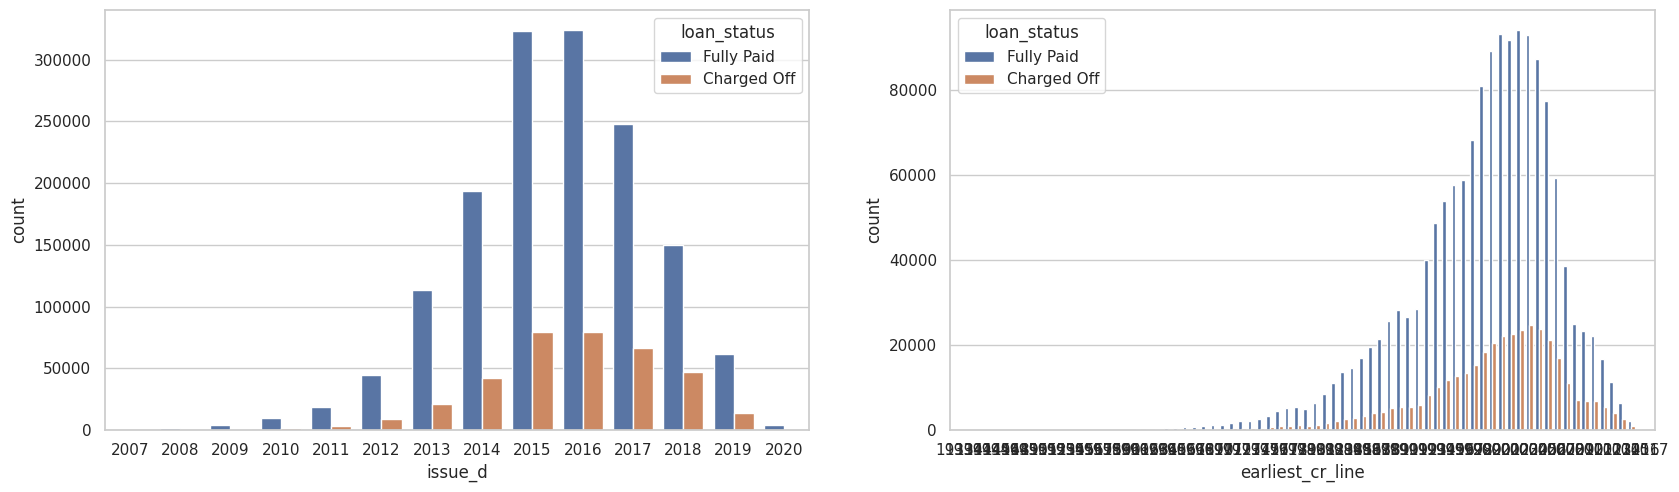

In [302]:
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.countplot(data=df, x="issue_d", hue="loan_status")

plt.subplot(2, 2, 2)
sns.countplot(data=df, x="earliest_cr_line", hue="loan_status")

### Dealing with outliers
By eye-balling, we can tell that most of the numerical feature's distributions are positively skewed, while `annual_inc`, `dti`, and `revol_bal` contain some outliers. We will look into `annual_inc`, `dti`, `revol_bal` carefully.

In [ ]:
print(f"Highest annual income: {df['annual_inc'].max():.2f}")
print(f"Average annual income: {df['annual_inc'].mean():.2f}")
print(f"Highest DTI ratio: {df['dti'].max():.2f}")
print(f"Average DTI ratio: {df['dti'].mean():.2f}")
print(f"Highest Revolving Balance: {df['revol_bal'].max():.2f}")
print(f"Average Revolving Balance: {df['revol_bal'].mean():.2f}")

Highest annual income: 110000000.00
Average annual income: 77369.56
Highest DTI ratio: 999.00
Average DTI ratio: 18.57
Highest Revolving Balance: 2904836.00
Average Revolving Balance: 16285.39


We observe that the maximum of these features are very far away from their mean value, so they are outliers.

However, the highest annual income recorded was 110,000,000 annually, so if we perform some transformation methods, such as Square root, they will still be outliers:

- `sqrt`(60,000) ≈ 244.95
- `sqrt`(110,000,000) ≈ 10488.09

It is still a wide range between those two values. Thus, we should think of some transformation methods that can penalize the extreme values and bring them onto a more even scale, such as Log Transformation:

- `log`(60,000) ≈ 4.78
- `log`(110,000,000) ≈ 8.04

This is a much more even scale as these two values are not far from each other. Now we would want to apply Log Transformation here, but our data contains 0 values in such numerical feature columns. We will analyze the meaning and importance of those 0 values.

In [ ]:
# @title
# annual_inc_counts = df['annual_inc'].value_counts().reset_index()
# annual_inc_counts.columns = ['Annual Income', 'Counts']

# dti_counts = df['dti'].value_counts().reset_index()
# dti_counts.columns = ['DTI', 'Counts']

# revol_bal_counts = df['revol_bal'].value_counts().reset_index()
# revol_bal_counts.columns = ['Revolving Balance', 'Counts']

In [ ]:
# @title
# %matplotlib inline
# plt.figure(figsize=(24, 12))
# sns.set(style="white")

# plt.subplot(3, 3, 1)
# sns.scatterplot(data=df, x=annual_inc_counts['Annual Income'], y=annual_inc_counts['Counts'], color='blue', s=60)
# plt.xlim((0, annual_inc_counts['Annual Income'].max()))
# plt.ylim((0, annual_inc_counts['Counts'].max()))

# plt.subplot(3, 3, 2)
# sns.scatterplot(data=df, x=dti_counts['DTI'], y=dti_counts['Counts'], color='blue', s=60)
# plt.xlim((0, dti_counts['DTI'].max()))
# plt.ylim((0, dti_counts['Counts'].max()))

# plt.subplot(3, 3, 3)
# sns.scatterplot(data=df, x=revol_bal_counts['Revolving Balance'], y=revol_bal_counts['Counts'], color='blue', s=60)
# plt.xlim((0, revol_bal_counts['Revolving Balance'].max()))
# plt.ylim((0, revol_bal_counts['Counts'].max()))

# plt.show()

### The meaning of 0

In [ ]:
def count_zero_values(data):
  '''
    Count the number of zero values in each feature
  '''
  counts = []
  zero_data = {}
  for i in data.columns:
    if data[i].dtype == float:
      total = (data[i] == 0).sum()
      zero_data[i] = [total]
  zero_df = pd.DataFrame(zero_data).T
  zero_df = zero_df.rename(columns={0: "Number of zeros"})
  return zero_df

In [ ]:
zero_numerical_df = count_zero_values(df)
zero_numerical_df

,Number of zeros
loan_amnt,0
int_rate,0
installment,0
annual_inc,1085
dti,1355
revol_bal,10327
revol_util,10915


This issue is quite challenging as we should prepare ourselves with some domain knowledge:
- Annual income (`annual_inc`): a person can earn no annual income, but that doesn't mean they aren't able to afford a loan. In some records, there are people with no annual income who owns or have mortgages, so their ability to qualify for a loan is still likely possible.
- DTI (`dti`): a person with a DTI ratio of 0 basically means that they have no debts to manage. In this case, their chance to qualify for a loan is pretty high, and it positively impacts their credit score.
- Revolving balance (`revol_bal`): a person with a revolving balance of 0 is similar to DTI ratio of 0, as they don't have any outstanding monthly debts to manage to pay back. It positively affects their chance to borrow the loan.
- Revolving utilization (`revol_util`): Again, a person with a revolving utilization rate of 0 means that they are using no portions of the available credit => more responsible credit behavior => positive impact on credit score.

Therefore, all the zero values in such column contribute meaningful information to the ability to afford a loan as these cases are likely to happen. Thus, we should not remove these values from our data.

In [ ]:
# def normalize_features(data):
#   '''
#     Normalize each numerical feature in our data
#     using Square root transformation
#   '''
#   for i in data.columns:
#     if data[i].dtype == float:
#       data[i] = np.sqrt(data[i])
#   return data

### Normalizing the distributions
There are a few methods to normalize skewed distributions which we are dealing with:
- Robust Scaler (IQR)
- Square root transformation
- Log transformation
- Box-Cox transformation

### The log-0 dilemma
Suppose an average person earns 60,000 annually, but there is another person making over 110,000,000 every year!. This wealthy person will be the outlier, thus the distribution will be skewed. If we choose to apply square root transformation:

- `sqrt`(60,000) ≈ 244.95
- `sqrt`(110,000,000) ≈ 10488.09

It is still a wide range between those two values. Thus, we should think of some transformation methods that can penalize the extreme values and bring them onto a more even scale, such as Log Transformation:

- `log`(60,000) ≈ 4.78
- `log`(110,000,000) ≈ 8.04

This range seems pretty good. Now, suppose there is another person earning no annual income. This can occur if that person retired and they are receiving pension.

- `log`(0) = ?

There is a huge problem with using Log transformation, as x approaches 0, `log`(x) approaches -inf, which means `log`(0) is undefined.


### Normalization technique analysis
- If we stick to the Log transformation method, there are 2 possible ways to deal with 0 values:

  1.  Add a small constant: we add a small constant C to all values before performing Log transformation, so we can avoid `log`(0).
  2.  Remove 0 values and perform Log transformation: this can be applied if the 0 values don't bring much information to our problem.

- Box-Cox transformation: this is oftenly used for skewed distributions, so that they will be transformed into normal distributions.

It is best to examine each method and decide which one performs the best.

In [ ]:
def log_transform(data):
  '''
    Normalize the numerical features by first adding a constant,
    then perform log transformation
  '''
  C = 1
  for i in data.columns:
    if data[i].dtype == float:
      data[i] = data[i] + C
      data[i] = np.log(data[i])
  return data

In [ ]:
log_test_data = df[:]                               # make a copy of df and pass into log_test_data
log_test_tf = log_transform(log_test_data)
log_test_tf.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,8.52,36 months,2.46,5.10,B,B2,OTHER,10+ years,RENT,10.09,Verified,2011-12-01,Fully Paid,credit_card,Computer,3.36,1985-01-01,3,0,9.52,4.44,9,f,Individual,2,0
1,7.82,60 months,2.79,4.11,C,C4,Ryder,< 1 year,RENT,10.31,Source Verified,2011-12-01,Charged Off,car,bike,0.69,1999-04-01,3,0,7.43,2.34,4,f,Individual,2,0
2,7.78,36 months,2.83,4.45,C,C5,OTHER,10+ years,RENT,9.41,Not Verified,2011-12-01,Fully Paid,small_business,real estate business,2.27,2001-11-01,2,0,7.99,4.60,10,f,Individual,2,0
3,9.21,36 months,2.67,5.83,C,C1,AIR RESOURCES BOARD,10+ years,RENT,10.80,Source Verified,2011-12-01,Fully Paid,other,personel,3.04,1996-02-01,10,0,8.63,3.09,37,f,Individual,2,0
4,8.01,60 months,2.62,4.23,B,B5,University Medical Group,1 year,RENT,11.29,Source Verified,2011-12-01,Fully Paid,other,Personal,2.94,1996-01-01,15,0,10.23,4.01,38,f,Individual,2,0


(0.0, 100.0)

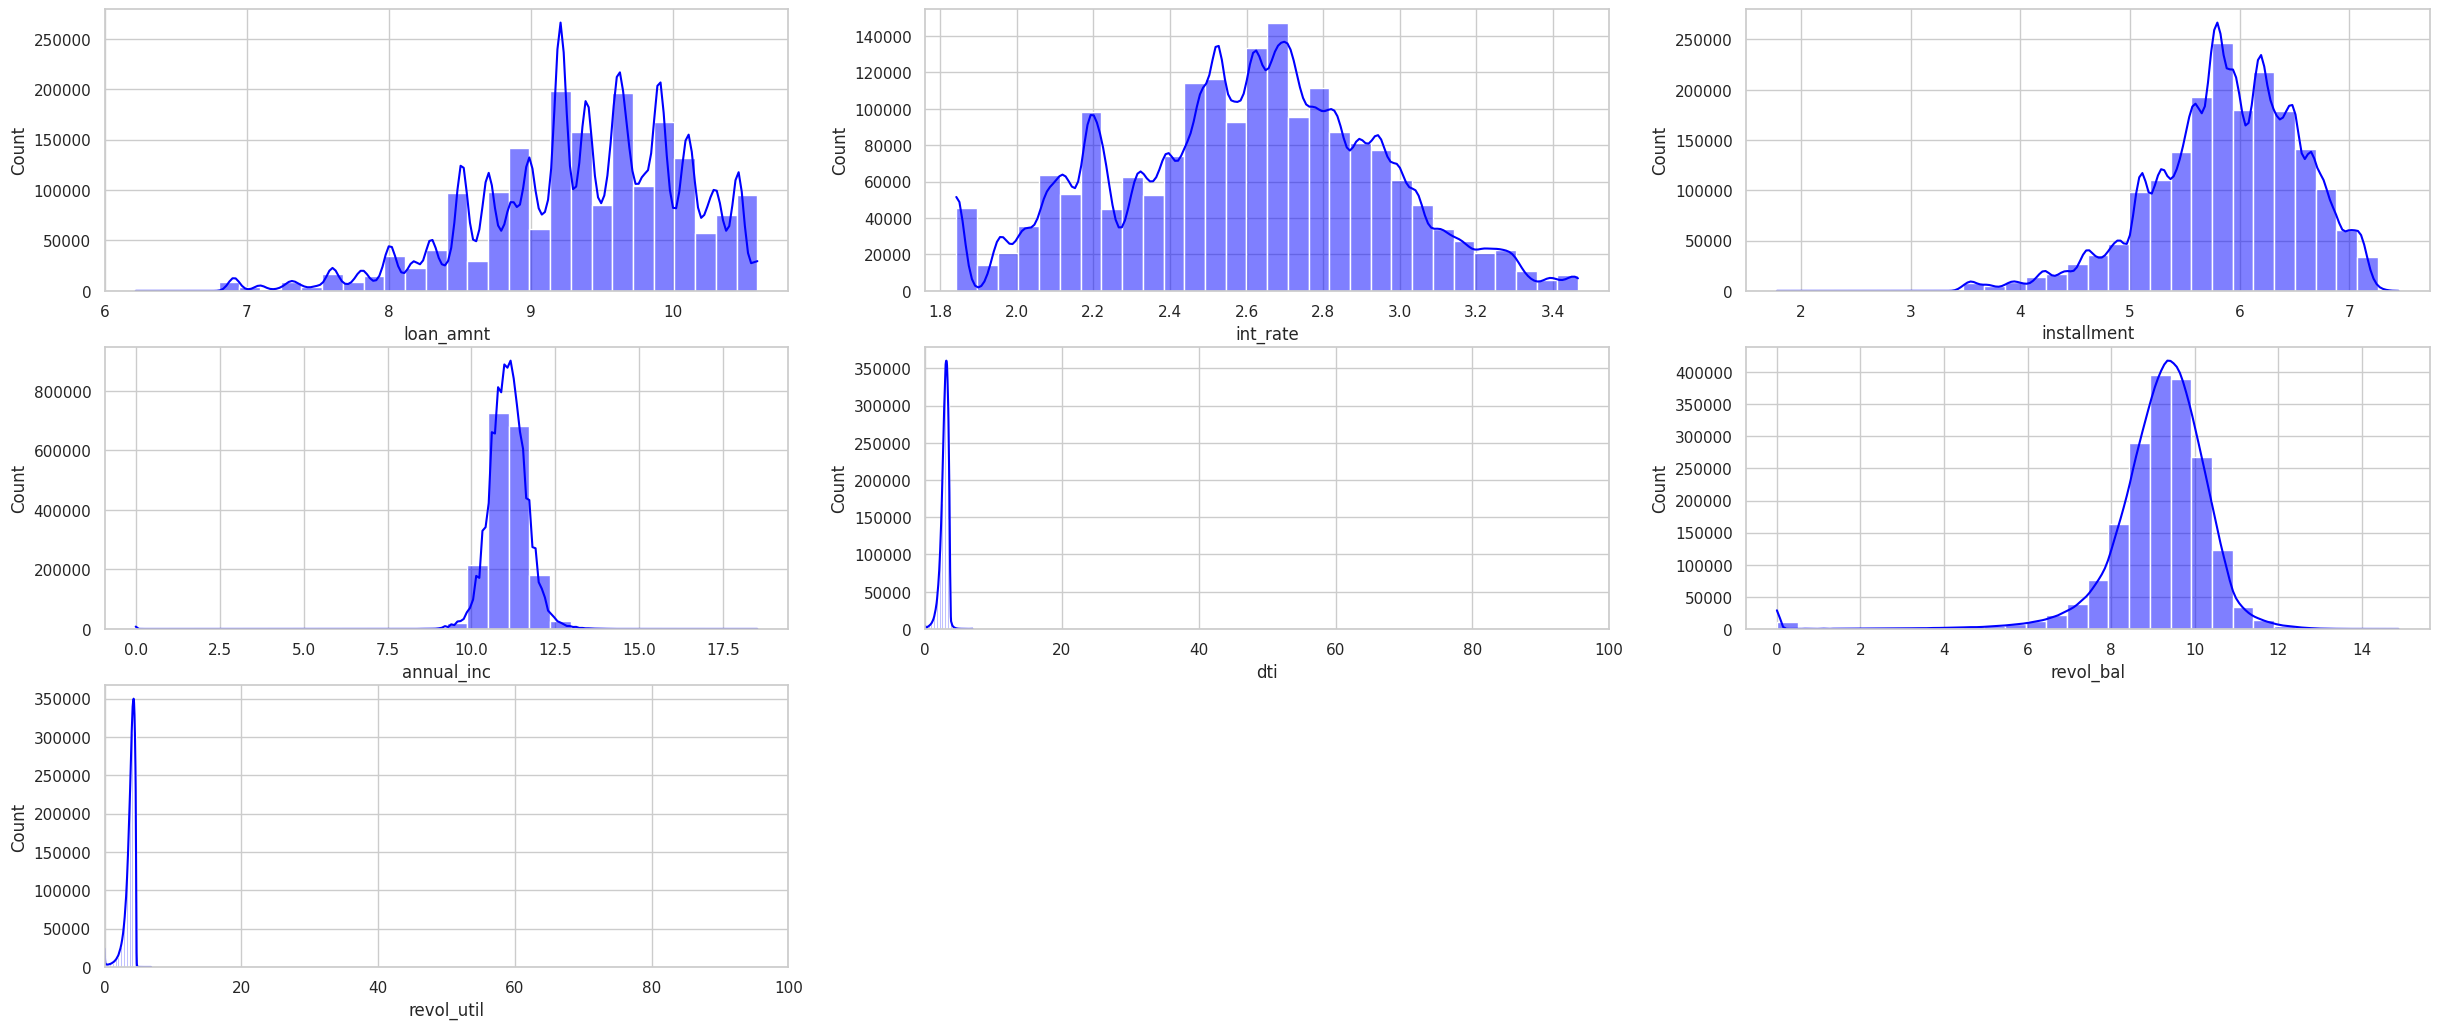

In [ ]:
# @title
plt.figure(figsize=(30, 30))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(7, 3, 1)
sns.histplot(x='loan_amnt', data=log_test_tf, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 2)
sns.histplot(x='int_rate', data=log_test_tf, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 3)
sns.histplot(x='installment', data=log_test_tf , bins=30, kde=True, color='blue')

plt.subplot(7, 3, 4)
sns.histplot(x='annual_inc', data=log_test_tf, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 5)
sns.histplot(x='dti', data=log_test_tf, bins=30, kde=True, color='blue')
plt.xlim(0, 100)


plt.subplot(7, 3, 6)
sns.histplot(x='revol_bal', data=log_test_tf, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 7)
sns.histplot(x='revol_util', data=log_test_tf, bins=30, kde=True, color='blue')
plt.xlim(0, 100)

<Axes: xlabel='revol_util'>

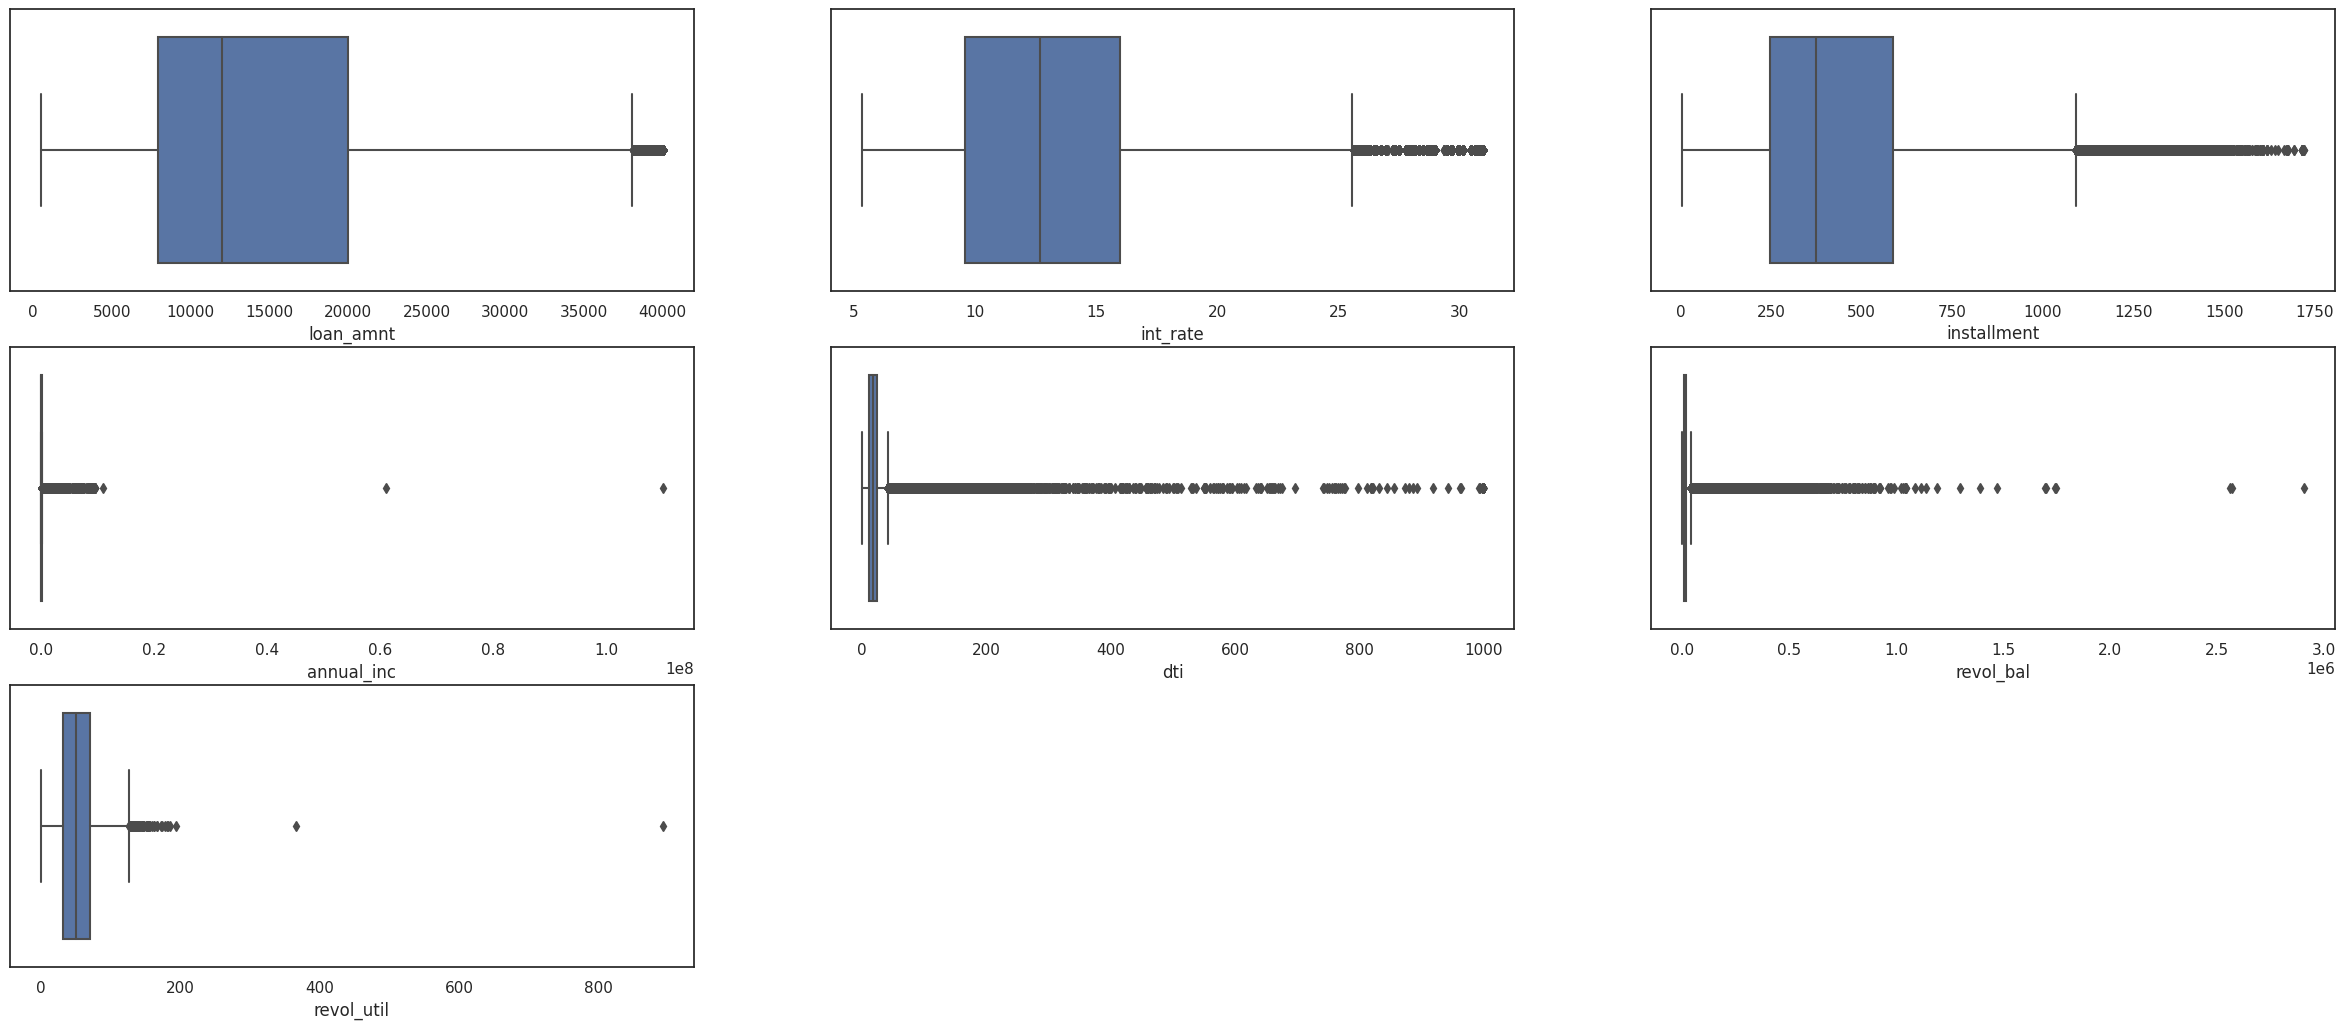

In [ ]:
# @title
plt.figure(figsize=(30, 30))  # Adjust the figure size as needed
sns.set(style="white")

plt.subplot(7, 3, 1)
sns.boxplot(x='loan_amnt', data=df)

plt.subplot(7, 3, 2)
sns.boxplot(x='int_rate', data=df)

plt.subplot(7, 3, 3)
sns.boxplot(x='installment', data=df)

plt.subplot(7, 3, 4)
sns.boxplot(x='annual_inc', data=df)

plt.subplot(7, 3, 5)
sns.boxplot(x='dti', data=df)


plt.subplot(7, 3, 6)
sns.boxplot(x='revol_bal', data=df)

plt.subplot(7, 3, 7)
sns.boxplot(x='revol_util', data=df)

In [ ]:
def sqrt_transform(data):
  '''
    Normalize each numerical feature in our data
    using Square root transformation
  '''
  for i in data.columns:
    if data[i].dtype == float:
      data[i] = np.sqrt(data[i])
  return data

In [ ]:
sqrt_transform_df = sqrt_transform(df[:])
sqrt_transform_df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,70.71,36 months,3.26,12.76,B,B2,OTHER,10+ years,RENT,154.92,Verified,2011-12-01,Fully Paid,credit_card,Computer,5.26,1985-01-01,3,0,116.82,9.15,9,f,Individual,2,0
1,50.00,60 months,3.91,7.73,C,C4,Ryder,< 1 year,RENT,173.21,Source Verified,2011-12-01,Charged Off,car,bike,1.00,1999-04-01,3,0,41.07,3.07,4,f,Individual,2,0
2,48.99,36 months,3.99,9.18,C,C5,OTHER,10+ years,RENT,110.69,Not Verified,2011-12-01,Fully Paid,small_business,real estate business,2.95,2001-11-01,2,0,54.37,9.92,10,f,Individual,2,0
3,100.00,36 months,3.67,18.42,C,C1,AIR RESOURCES BOARD,10+ years,RENT,221.81,Source Verified,2011-12-01,Fully Paid,other,personel,4.47,1996-02-01,10,0,74.82,4.58,37,f,Individual,2,0
4,54.77,60 months,3.56,8.23,B,B5,University Medical Group,1 year,RENT,282.84,Source Verified,2011-12-01,Fully Paid,other,Personal,4.24,1996-01-01,15,0,166.68,7.34,38,f,Individual,2,0


(0.0, 100.0)

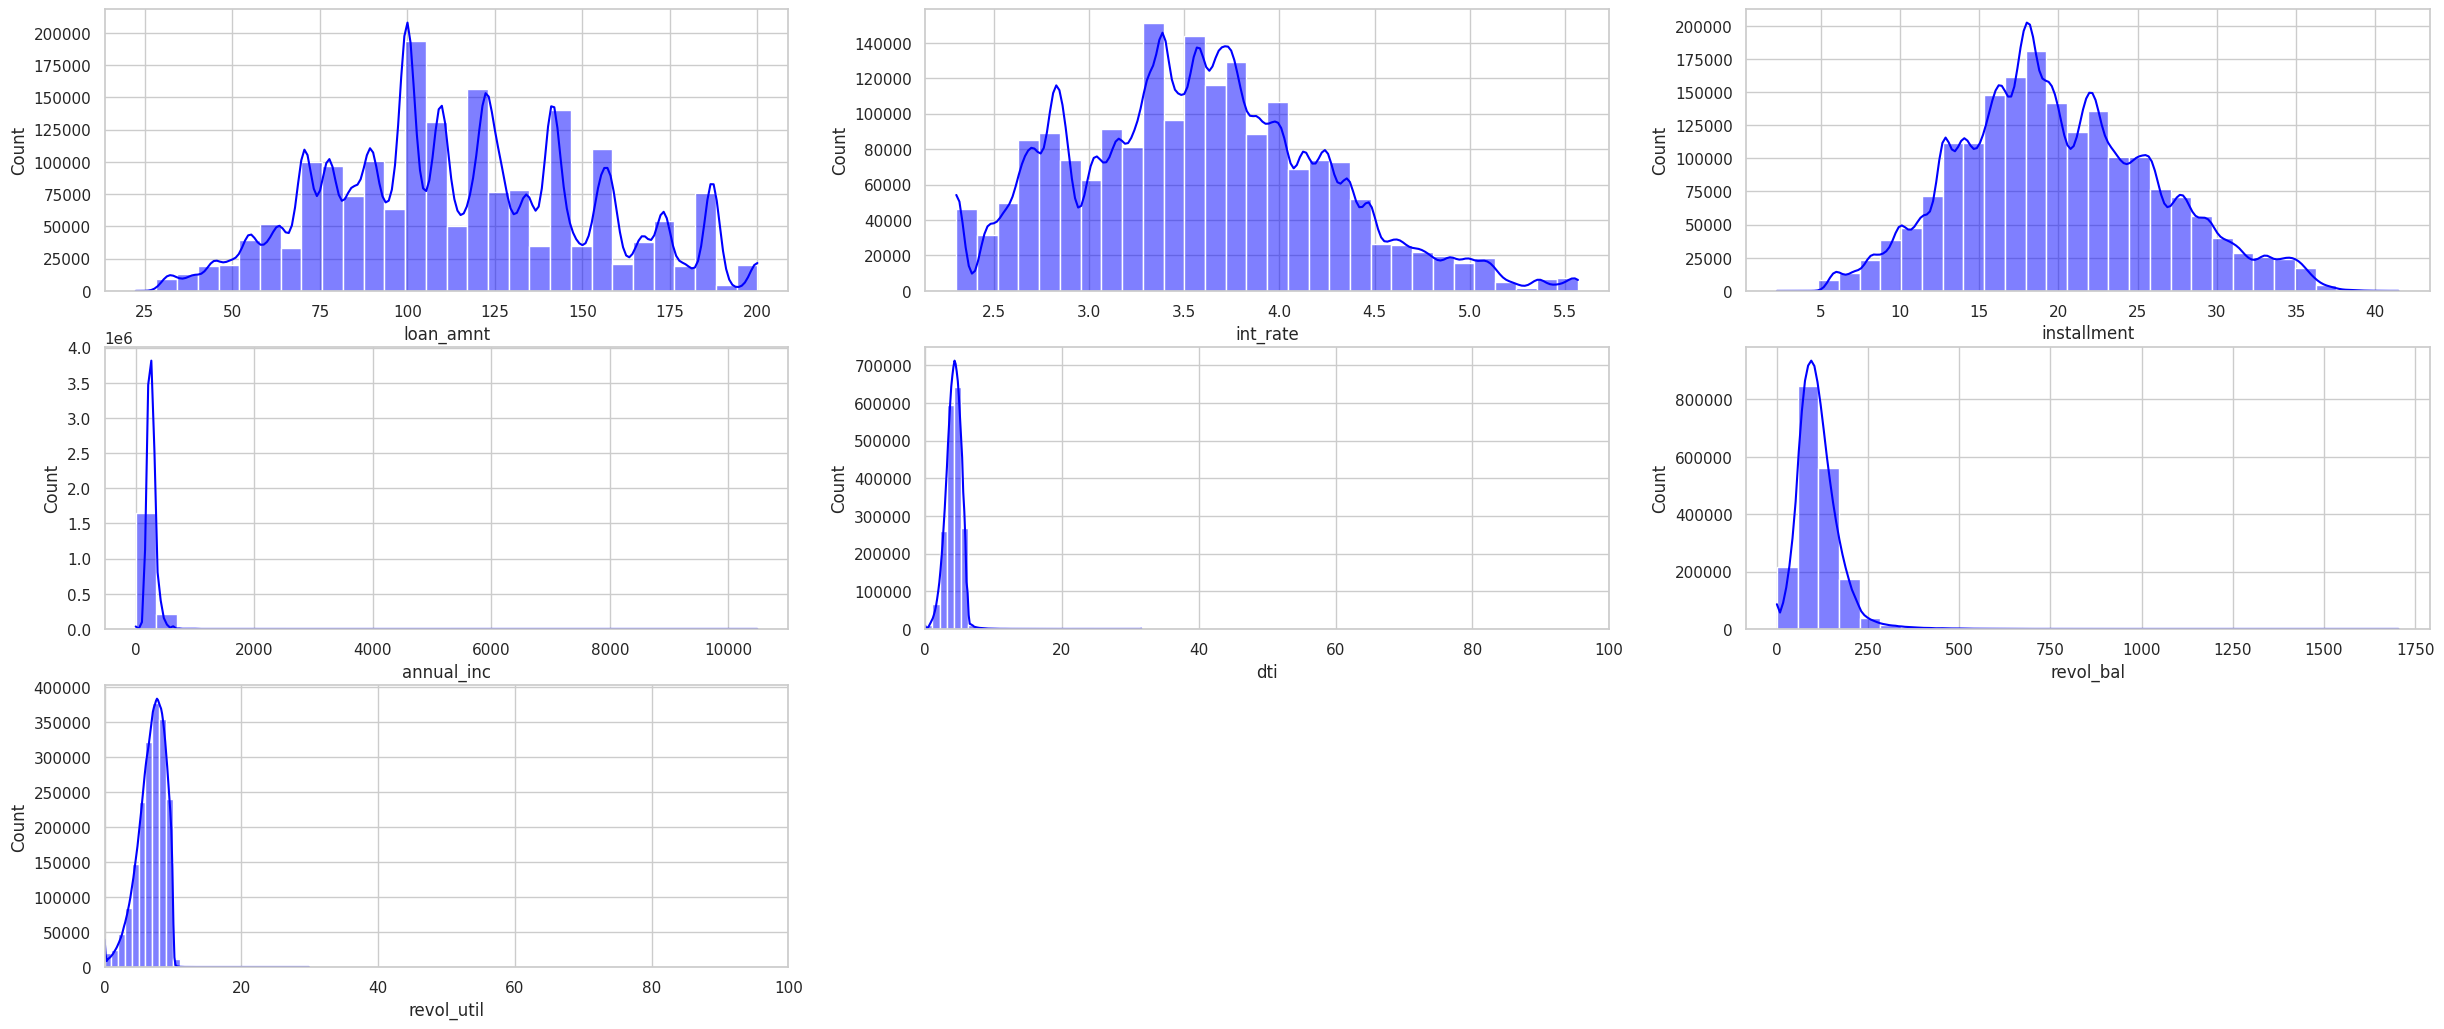

In [ ]:
# @title
plt.figure(figsize=(30, 30))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(7, 3, 1)
sns.histplot(x='loan_amnt', data=sqrt_transform_df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 2)
sns.histplot(x='int_rate', data=sqrt_transform_df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 3)
sns.histplot(x='installment', data=sqrt_transform_df , bins=30, kde=True, color='blue')

plt.subplot(7, 3, 4)
sns.histplot(x='annual_inc', data=sqrt_transform_df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 5)
sns.histplot(x='dti', data=sqrt_transform_df, bins=30, kde=True, color='blue')
plt.xlim(0, 100)


plt.subplot(7, 3, 6)
sns.histplot(x='revol_bal', data=sqrt_transform_df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 7)
sns.histplot(x='revol_util', data=sqrt_transform_df, bins=30, kde=True, color='blue')
plt.xlim(0, 100)

<Axes: xlabel='revol_util'>

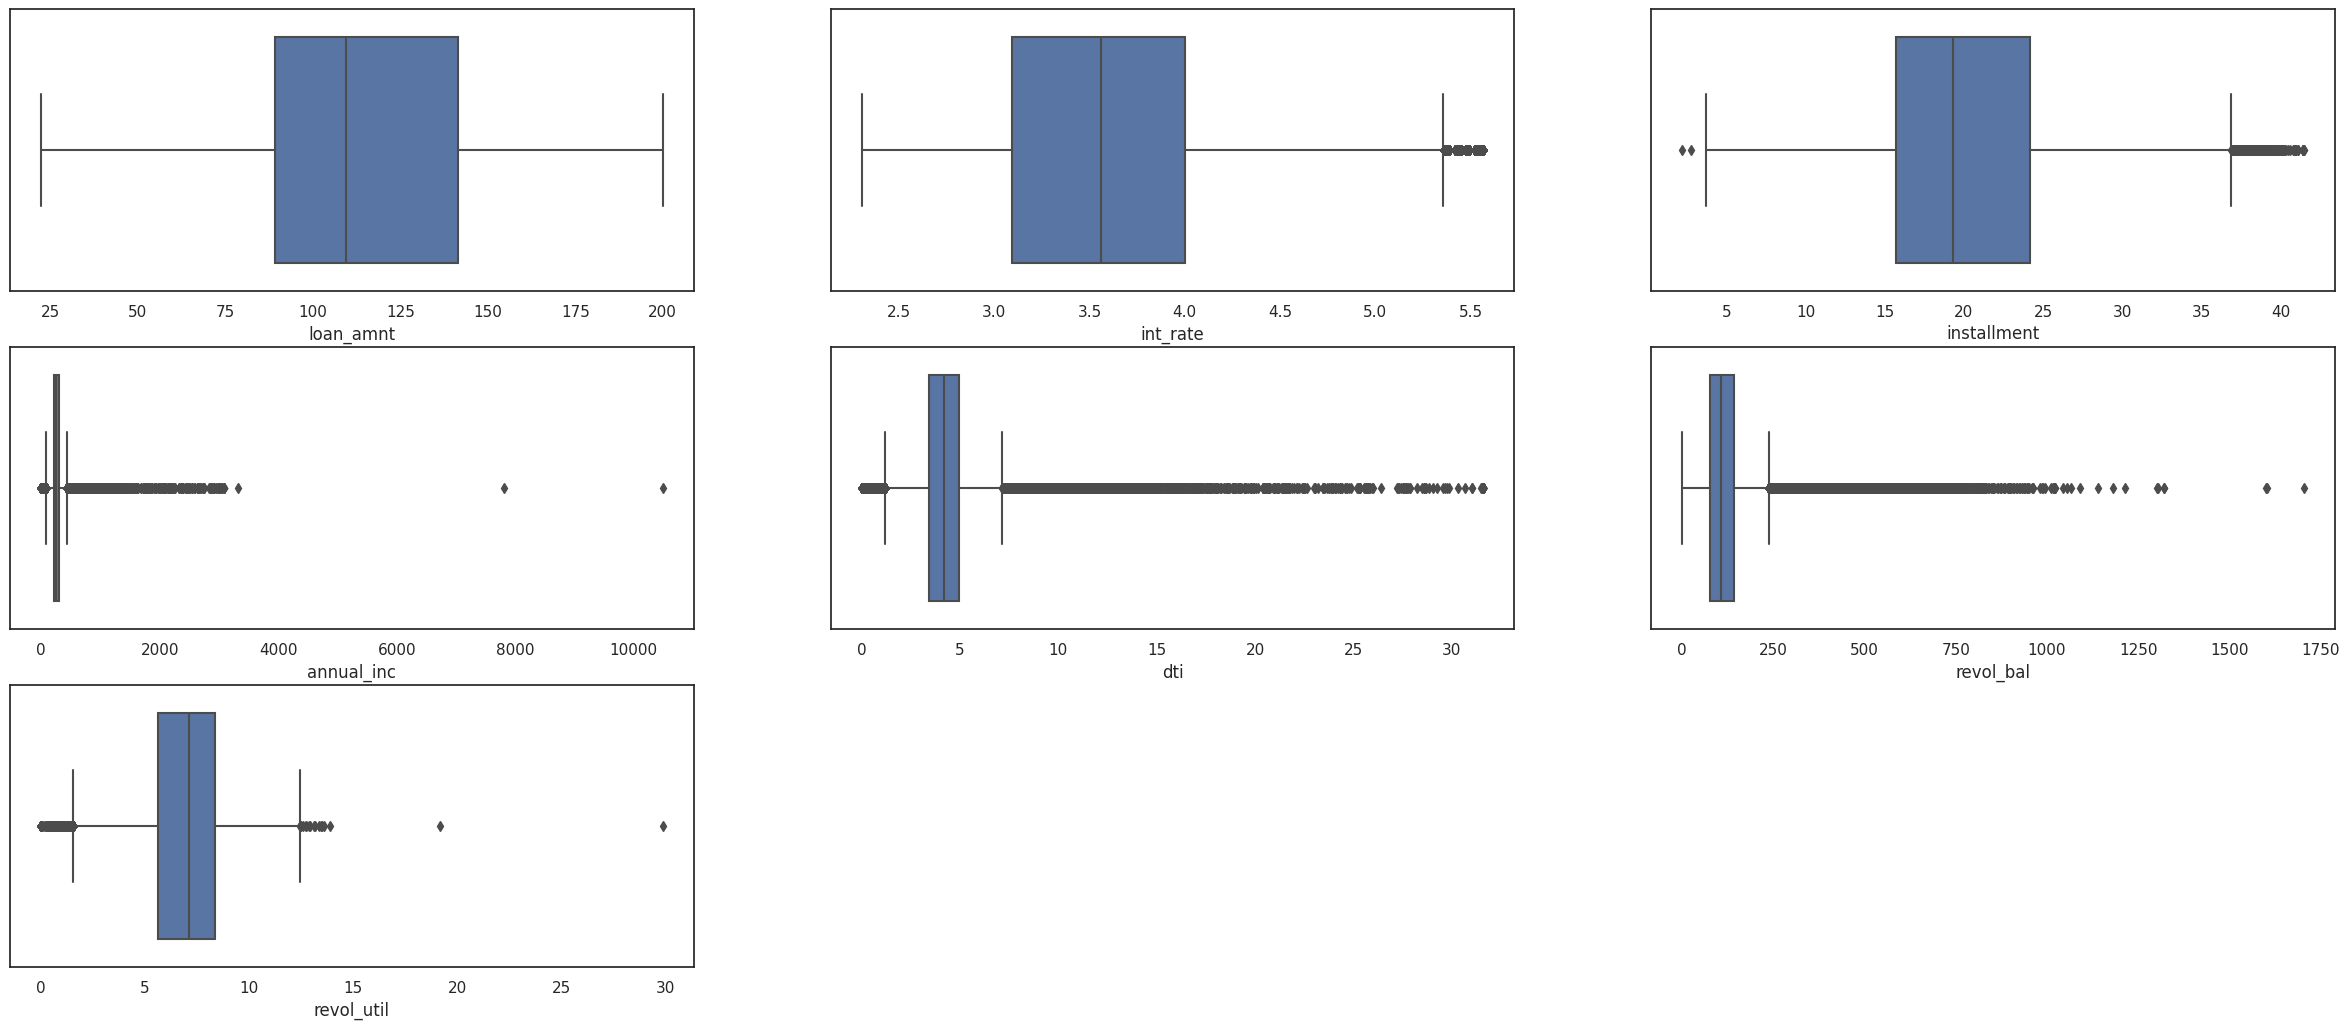

In [ ]:
# @title
plt.figure(figsize=(30, 30))  # Adjust the figure size as needed
sns.set(style="white")

plt.subplot(7, 3, 1)
sns.boxplot(x='loan_amnt', data=sqrt_transform_df)

plt.subplot(7, 3, 2)
sns.boxplot(x='int_rate', data=sqrt_transform_df)

plt.subplot(7, 3, 3)
sns.boxplot(x='installment', data=sqrt_transform_df)

plt.subplot(7, 3, 4)
sns.boxplot(x='annual_inc', data=sqrt_transform_df)

plt.subplot(7, 3, 5)
sns.boxplot(x='dti', data=sqrt_transform_df)


plt.subplot(7, 3, 6)
sns.boxplot(x='revol_bal', data=sqrt_transform_df)

plt.subplot(7, 3, 7)
sns.boxplot(x='revol_util', data=sqrt_transform_df)

In [ ]:
def robust_filter(data):
  '''
    Filter float-type, numerical features
  '''
  robust_df = {}
  for i in data.columns:
    if data[i].dtype == float:
      robust_df[i] = data[i].values
  robust_df = pd.DataFrame(robust_df)
  return robust_df

In [ ]:
robust_filter_df = robust_filter(df[:])
robust_filter_df

,loan_amnt,int_rate,installment,annual_inc,dti,revol_bal,revol_util
0,5000.00,10.65,162.87,24000.00,27.65,13648.00,83.70
1,2500.00,15.27,59.83,30000.00,1.00,1687.00,9.40
2,2400.00,15.96,84.33,12252.00,8.72,2956.00,98.50
3,10000.00,13.49,339.31,49200.00,20.00,5598.00,21.00
4,3000.00,12.69,67.79,80000.00,17.94,27783.00,53.90
...,...,...,...,...,...,...,...
1860324,24000.00,23.99,690.30,107000.00,11.65,9688.00,24.90
1860325,10000.00,7.99,313.32,65000.00,19.55,9751.00,15.70
1860326,10050.00,16.99,358.26,37000.00,20.56,14300.00,47.00
1860327,6000.00,11.44,197.69,41000.00,19.99,1356.00,10.10


In [ ]:
def robust_scaler(data):
  '''
    Normalize each numerical feature in our data
    using RobustScaler (IQR)
  '''
  scaler = RobustScaler()
  robust_transform_df = scaler.fit_transform(data)
  robust_transform_df = pd.DataFrame(robust_transform_df)
  col_mapping = {i: idx for i, idx in enumerate(data)}
  robust_transform_df.rename(columns=col_mapping, inplace=True)
  return robust_transform_df

In [ ]:
robust_transform_df = robust_scaler(robust_filter_df)
robust_transform_df

,loan_amnt,int_rate,installment,annual_inc,dti,revol_bal,revol_util
0,-0.58,-0.32,-0.62,-0.89,0.80,0.19,0.87
1,-0.79,0.40,-0.93,-0.76,-1.34,-0.67,-1.08
2,-0.80,0.51,-0.86,-1.15,-0.72,-0.58,1.26
3,-0.17,0.12,-0.10,-0.34,0.18,-0.39,-0.78
4,-0.75,0.00,-0.90,0.33,0.02,1.20,0.09
...,...,...,...,...,...,...,...
1860324,1.00,1.76,0.94,0.91,-0.49,-0.10,-0.67
1860325,-0.17,-0.73,-0.18,0.00,0.15,-0.09,-0.92
1860326,-0.16,0.67,-0.05,-0.61,0.23,0.23,-0.09
1860327,-0.50,-0.19,-0.52,-0.52,0.18,-0.70,-1.06


(0.0, 100.0)

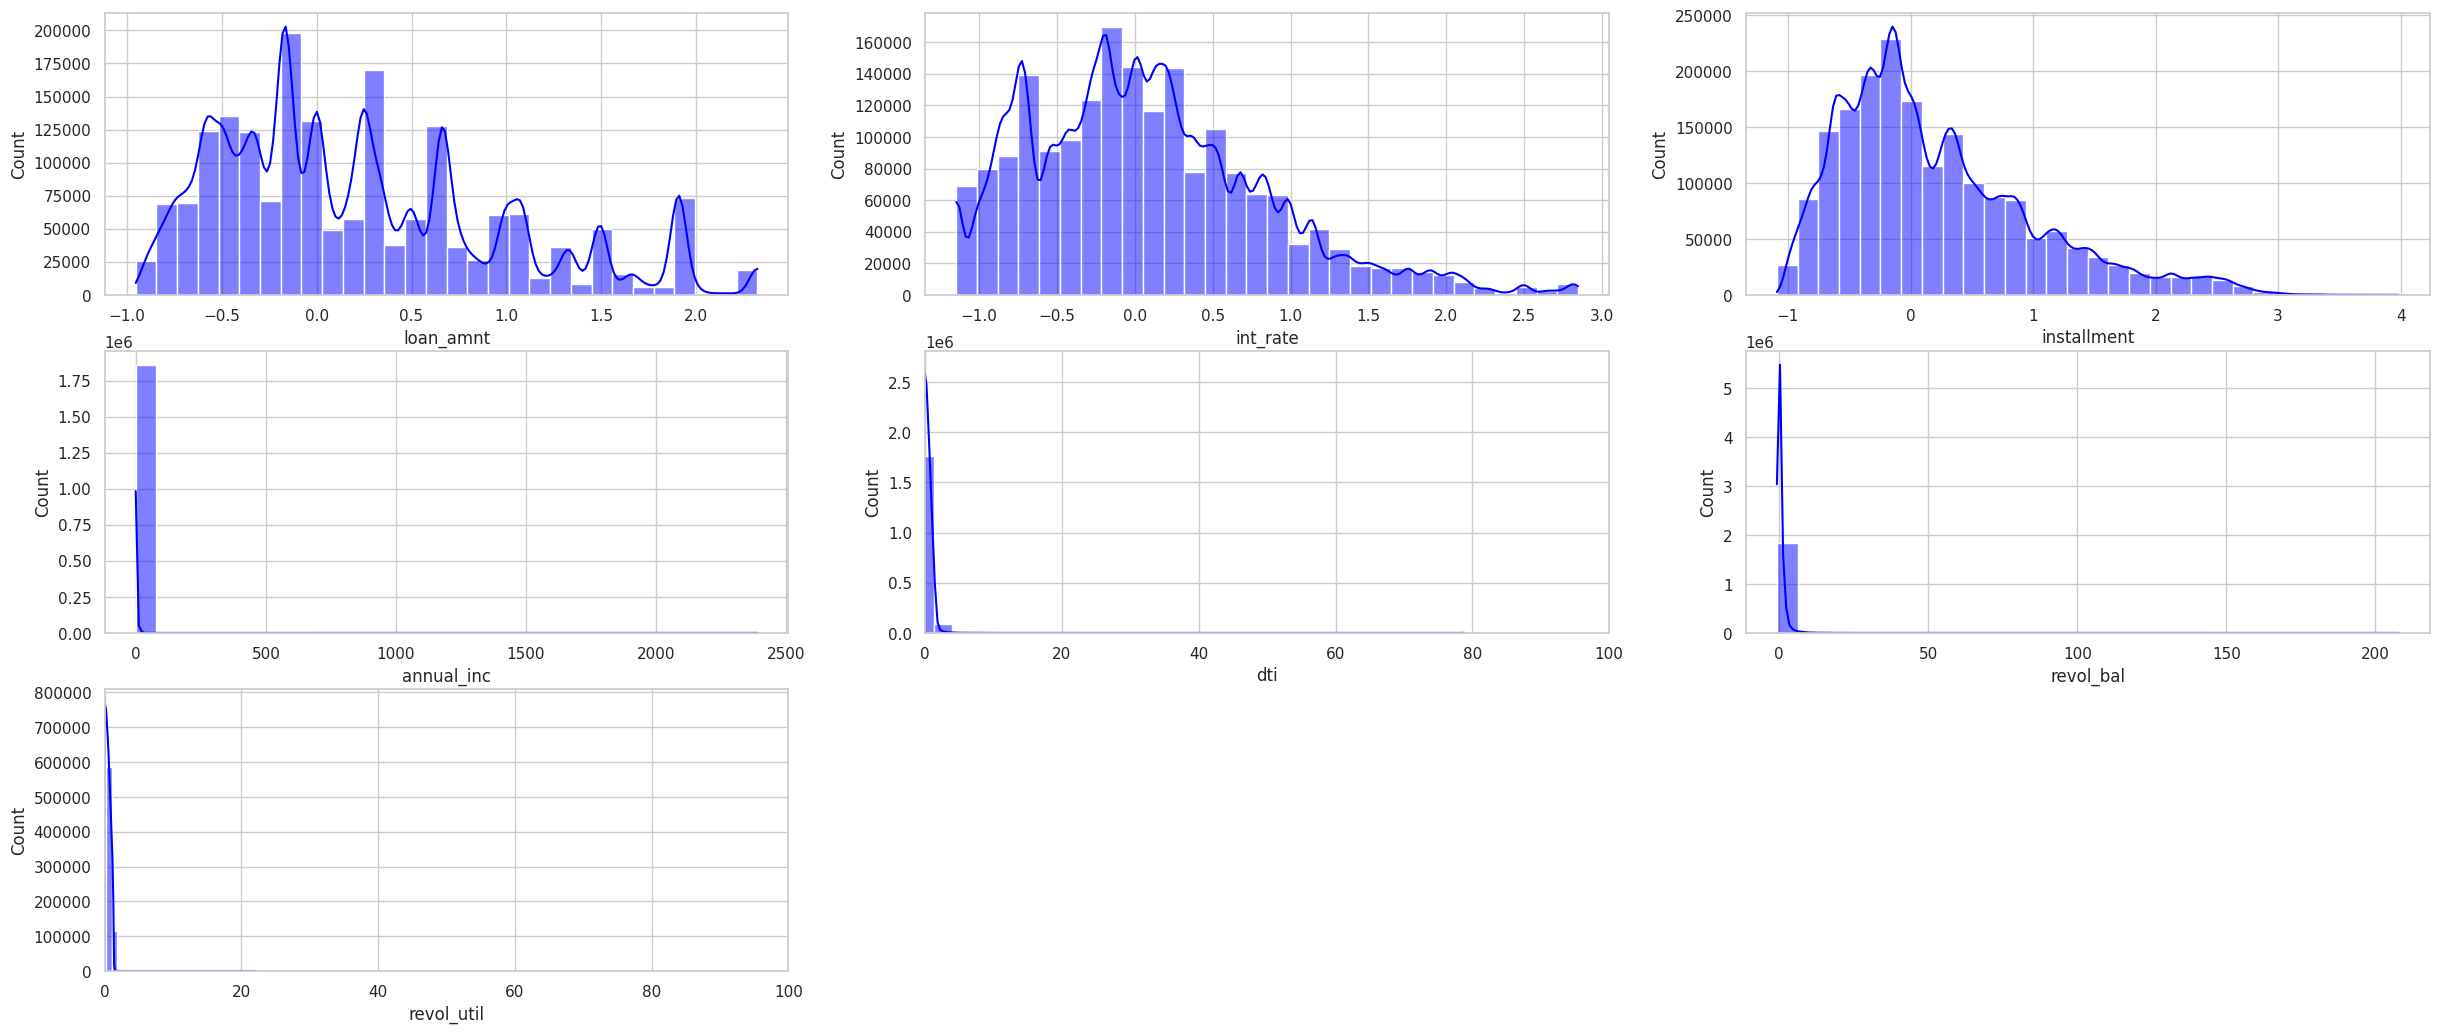

In [ ]:
# @title
plt.figure(figsize=(30, 30))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(7, 3, 1)
sns.histplot(x='loan_amnt', data=robust_transform_df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 2)
sns.histplot(x='int_rate', data=robust_transform_df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 3)
sns.histplot(x='installment', data=robust_transform_df , bins=30, kde=True, color='blue')

plt.subplot(7, 3, 4)
sns.histplot(x='annual_inc', data=robust_transform_df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 5)
sns.histplot(x='dti', data=robust_transform_df, bins=30, kde=True, color='blue')
plt.xlim(0, 100)


plt.subplot(7, 3, 6)
sns.histplot(x='revol_bal', data=robust_transform_df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 7)
sns.histplot(x='revol_util', data=robust_transform_df, bins=30, kde=True, color='blue')
plt.xlim(0, 100)

Among those scaling techniques, it can be observed that Square Root transforms the skewed distribution to normal distribution best.

### Correlation among numerical features

We visualize the correlation among numerical features after scaling.

<ipython-input-81-304756e98a6a>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(sqrt_transform_df.corr(), annot = True, cmap = 'YlGnBu')


<Axes: >

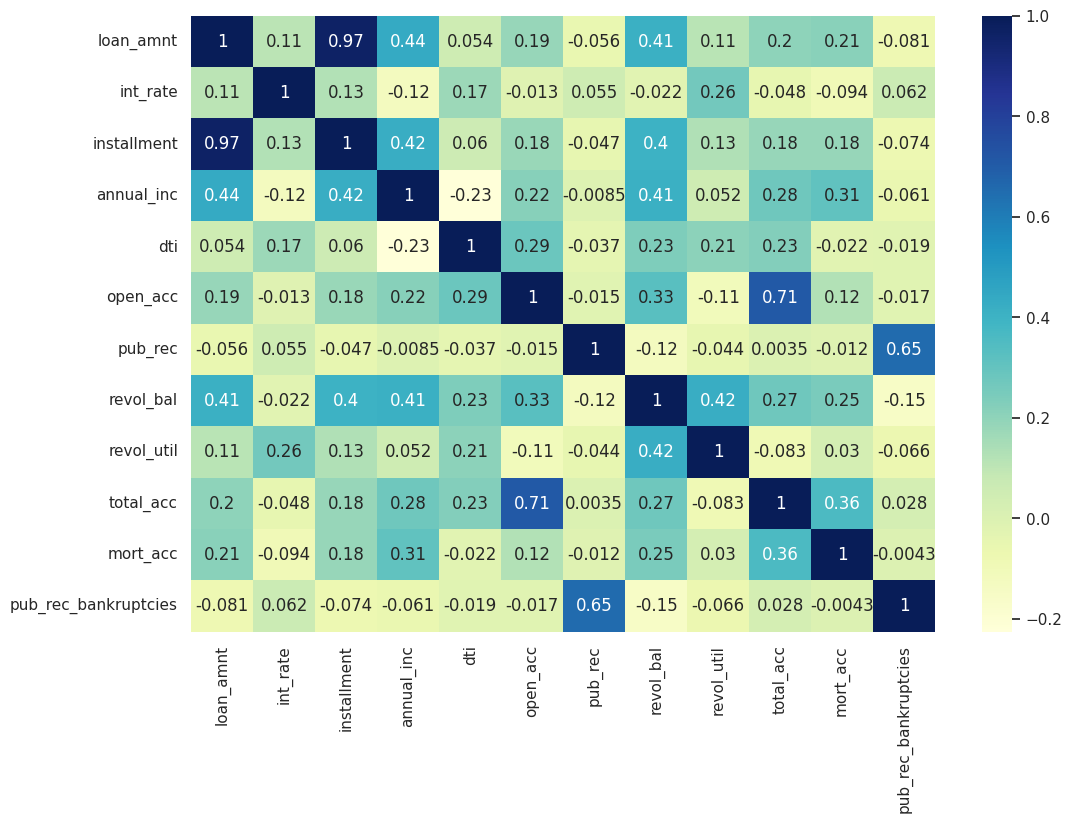

In [ ]:
# correlation between features
plt.figure(figsize=(12, 8))
sns.heatmap(sqrt_transform_df.corr(), annot = True, cmap = 'YlGnBu')

We observe that `loan_amnt` and `installment` share a very high correlation, so there may be potential duplicate information between the 2 features. We will take a closer look at them.

`loan_amnt` & `installment`

<Axes: xlabel='installment', ylabel='loan_status'>

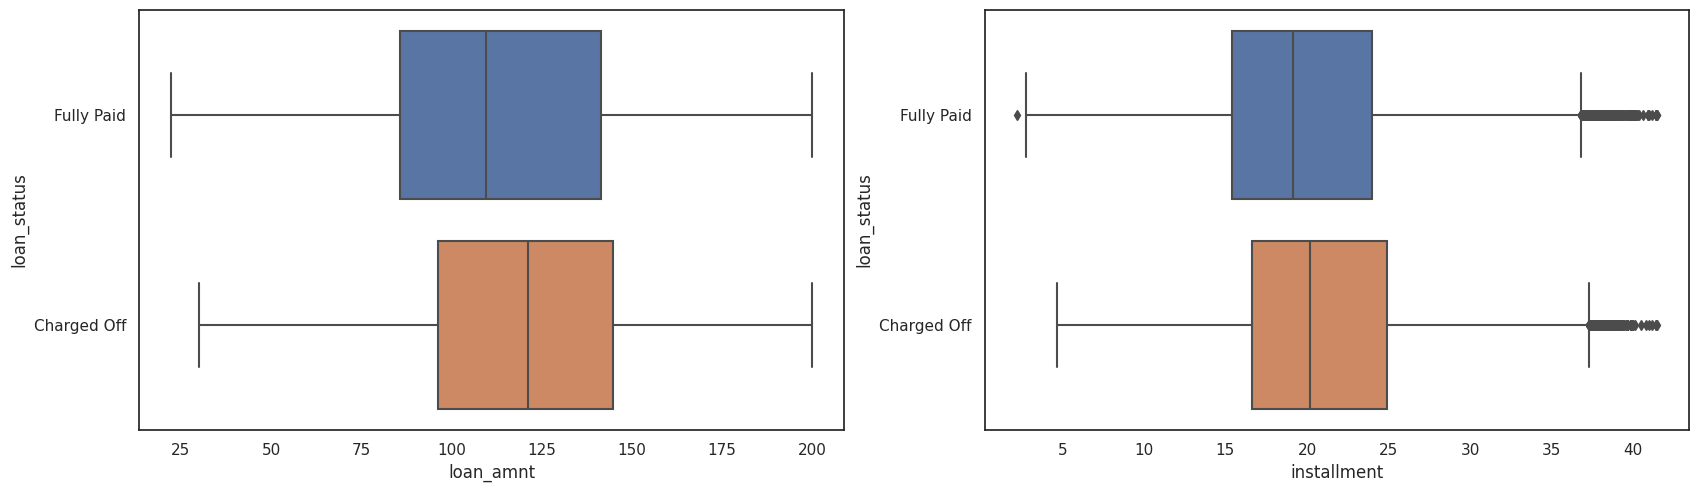

In [ ]:
# @title
plt.figure(figsize=(20, 12))
sns.set(style="white")

plt.subplot(2, 2, 1)
sns.boxplot(x='loan_amnt', y='loan_status', data=sqrt_transform_df)

plt.subplot(2, 2, 2)
sns.boxplot(x='installment', y='loan_status', data=sqrt_transform_df)

While `loan_amnt` is evenly distributed, `installment` still contains some outliers after transformation.

`annual_inc` & `int_rate`

We want to see that with the annual income, how many people weren't approved for a loan, and the same with interest rate.

<Axes: xlabel='int_rate', ylabel='loan_status'>

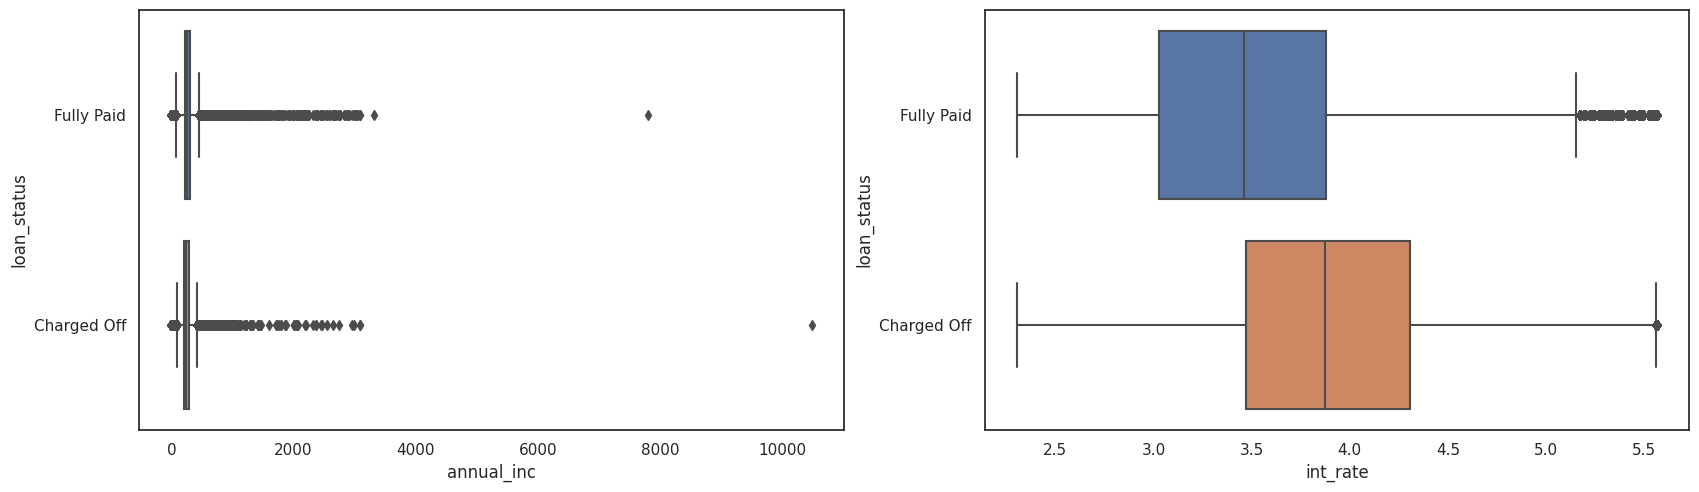

In [ ]:
# @title
plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
sns.boxplot(x='annual_inc', y='loan_status', data=sqrt_transform_df)

plt.subplot(2, 2, 2)
sns.boxplot(x='int_rate', y='loan_status', data=sqrt_transform_df)

In [ ]:
df

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,5000.00,36 months,10.65,162.87,B,B2,OTHER,10+ years,RENT,24000.00,Verified,2011-12-01,Fully Paid,credit_card,Computer,27.65,1985-01-01,3,0,13648.00,83.70,9,f,Individual,2,0
1,2500.00,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.00,Source Verified,2011-12-01,Charged Off,car,bike,1.00,1999-04-01,3,0,1687.00,9.40,4,f,Individual,2,0
2,2400.00,36 months,15.96,84.33,C,C5,OTHER,10+ years,RENT,12252.00,Not Verified,2011-12-01,Fully Paid,small_business,real estate business,8.72,2001-11-01,2,0,2956.00,98.50,10,f,Individual,2,0
3,10000.00,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.00,Source Verified,2011-12-01,Fully Paid,other,personel,20.00,1996-02-01,10,0,5598.00,21.00,37,f,Individual,2,0
4,3000.00,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.00,Source Verified,2011-12-01,Fully Paid,other,Personal,17.94,1996-01-01,15,0,27783.00,53.90,38,f,Individual,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860327,24000.00,60 months,23.99,690.30,E,E2,Senior Escrow Officer,< 1 year,RENT,107000.00,Source Verified,2017-04-01,Charged Off,other,Other,11.65,1995-04-01,13,2,9688.00,24.90,24,f,Individual,0,1
1860328,10000.00,36 months,7.99,313.32,A,A5,Rn,10+ years,MORTGAGE,65000.00,Source Verified,2017-04-01,Fully Paid,debt_consolidation,Debt consolidation,19.55,1993-09-01,15,0,9751.00,15.70,27,w,Individual,0,0
1860329,10050.00,36 months,16.99,358.26,D,D1,Sales Associate,8 years,RENT,37000.00,Not Verified,2017-04-01,Charged Off,debt_consolidation,Debt consolidation,20.56,1993-05-01,15,0,14300.00,47.00,21,w,Individual,0,0
1860330,6000.00,36 months,11.44,197.69,B,B4,Contact input,5 years,RENT,41000.00,Source Verified,2017-04-01,Fully Paid,credit_card,Credit card refinancing,19.99,1990-05-01,9,0,1356.00,10.10,18,w,Individual,0,0


## Categorical features
- `grade`, `sub_grade`, `emp_title`, `home_ownership`, `verification_status`, `purpose`, `title`, `application_type`

Before we move on with encoding categorical features, we should address the contribution of some features and remove some of them.

`grade`: we notice that sub_grade is a more detailed version of grade, so we will drop grade.

In [ ]:
df.drop('grade', axis=1, inplace=True)

`emp_length`: we see that employment length doesn't really matter to the charged interest rate, as the company charges the same regardless of how long you have been working => remove.

In [ ]:
df.drop('emp_length', axis=1, inplace=True)

`issue_d`: as we don't know if a person will be qualified for a loan or not before using our model, so we can't have an issue date => drop

In [ ]:
df.drop('issue_d', axis=1, inplace=True)

`emp_title`: In the stance of lenders, they are more interested in your income rather than your job title. If you earn good money without even specifying your job title, you are still more likely to get a loan rather than someone who has a stable job but low income. Thus, this feature column may not contribute much information to the qualification for a loan => Drop

In [ ]:
df.drop('emp_title', axis=1, inplace=True)

`purpose` & `title`: this 2 features have the similar information, so we drop `title`

In [ ]:
df.drop('title', axis=1, inplace=True)

`earliest_cr_line`: the month the borrower's earliest credit line was opened. This is a historical feature, so we would convert them into years and numerical.

In [ ]:
df['earliest_cr_line'] = df.earliest_cr_line.dt.year

### Categorical feature's dictionary

In [ ]:
df['term'].value_counts()

 36 months    1393298
 60 months     467031
Name: term, dtype: int64

In [ ]:
df['sub_grade'].value_counts()

C1    118945
B5    116578
B4    115826
B3    109910
C2    108096
C3    103561
C4    102722
B2    102207
B1    102081
C5     94782
A5     89191
A4     77087
D1     69175
A1     67298
D2     63918
A3     57423
A2     55318
D3     54073
D4     47571
D5     40264
E1     29399
E2     26137
E3     22837
E4     19433
E5     18694
F1     11749
F2      8284
F3      6959
F4      5520
F5      4596
G1      3578
G2      2437
G3      1851
G4      1490
G5      1339
Name: sub_grade, dtype: int64

In [ ]:
df['home_ownership'].value_counts()

MORTGAGE    918026
RENT        735358
OWN         205578
ANY           1174
OTHER          144
NONE            49
Name: home_ownership, dtype: int64

In [ ]:
df['verification_status'].value_counts()

Source Verified    734067
Not Verified       588360
Verified           537902
Name: verification_status, dtype: int64

In [ ]:
df['purpose'].value_counts()

debt_consolidation    1063457
credit_card            412844
home_improvement       123861
other                  113589
major_purchase          41750
medical                 22578
small_business          20515
car                     20215
vacation                13333
moving                  13203
house                   11099
wedding                  2298
renewable_energy         1260
educational               327
Name: purpose, dtype: int64

In [ ]:
df['application_type'].value_counts()

Individual    1790837
Joint App       69492
Name: application_type, dtype: int64

### One-hot encoding
We will perform one-hot encoding for the above categorical features by assigning them to dummy variables.

In [ ]:
dummies_var = ['term', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'application_type']
df = pd.get_dummies(df, columns=dummies_var, drop_first=True)

In [ ]:
df

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mort_acc,pub_rec_bankruptcies,term_ 60 months,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,...,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Joint App
0,5000.00,10.65,162.87,24000.00,Fully Paid,27.65,1985,3,0,13648.00,83.70,9,f,2,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2500.00,15.27,59.83,30000.00,Charged Off,1.00,1999,3,0,1687.00,9.40,4,f,2,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2400.00,15.96,84.33,12252.00,Fully Paid,8.72,2001,2,0,2956.00,98.50,10,f,2,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,10000.00,13.49,339.31,49200.00,Fully Paid,20.00,1996,10,0,5598.00,21.00,37,f,2,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,3000.00,12.69,67.79,80000.00,Fully Paid,17.94,1996,15,0,27783.00,53.90,38,f,2,0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860327,24000.00,23.99,690.30,107000.00,Charged Off,11.65,1995,13,2,9688.00,24.90,24,f,0,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1860328,10000.00,7.99,313.32,65000.00,Fully Paid,19.55,1993,15,0,9751.00,15.70,27,w,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1860329,10050.00,16.99,358.26,37000.00,Charged Off,20.56,1993,15,0,14300.00,47.00,21,w,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1860330,6000.00,11.44,197.69,41000.00,Fully Paid,19.99,1990,9,0,1356.00,10.10,18,w,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
loan_status_counts = df['loan_status'].value_counts()

loan_status_df = pd.DataFrame({
    'Loan Status': loan_status_counts.index,
    'Counts': loan_status_counts.values
})

loan_status_df

,Loan Status,Counts
0,Fully Paid,1497781
1,Charged Off,362548


In [ ]:
df.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1860329 entries, 0 to 1860331
Data columns (total 71 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_amnt                            1860329 non-null  float64
 1   int_rate                             1860329 non-null  float64
 2   installment                          1860329 non-null  float64
 3   annual_inc                           1860329 non-null  float64
 4   loan_status                          1860329 non-null  object 
 5   dti                                  1860329 non-null  float64
 6   earliest_cr_line                     1860329 non-null  int64  
 7   open_acc                             1860329 non-null  int64  
 8   pub_rec                              1860329 non-null  int64  
 9   revol_bal                            1860329 non-null  float64
 10  revol_util                           1860329 non-null  float64
 11

In [ ]:
df.loc[(df.home_ownership == 'NONE') | (df.home_ownership == 'ANY'), 'home_ownership'] = 'OTHER'
df.home_ownership.value_counts()

AttributeError: ignored